In [2]:
from sklearn.naive_bayes import BernoulliNB
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("dis_sym_dataset_comb (1).csv")

In [4]:
df

,label_dis,abdominal cramp,abdominal distention,abnormal behavior,abnormal bleeding,abnormal sensation,abnormally frequent,abscess,aching,acne,...,wet,wheezing,white patch vaginal discharge,widespread pain,withdrawal occurring stopping,worrying,yellow skin,yellowish coloration skin white eye,yellowish skin,yellowish skin crust
0,Abscess,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Abscess,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Abscess,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Abscess,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Abscess,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8830,papilloedema,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8831,papilloedema,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8832,papilloedema,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8833,papilloedema,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X = df.drop(columns='label_dis')
y = df['label_dis']

nb_classifier = BernoulliNB()
nb_classifier.fit(X, y)

feature_probabilities = nb_classifier.feature_log_prob_
probabilities = pd.DataFrame(np.exp(feature_probabilities), columns=df.columns[1:])

grouped = df.groupby('label_dis')

probabilities_dict = {}

In [6]:
average_probabilities_dict = {}

for name, group in grouped:
    group_features = group.drop(columns='label_dis')
    
    symptom_probs = probabilities.loc[0][group_features.columns] * group_features
    
    total_prob = symptom_probs.sum(axis=1)
    
    relative_probs = symptom_probs.div(total_prob, axis=0)
    
    non_zero_probs = relative_probs.loc[:, (relative_probs > 0).any()]
    
    avg_probabilities = non_zero_probs.mean(axis=0)
    
    average_probabilities_dict[name] = avg_probabilities

for disease, avg_probs in average_probabilities_dict.items():
    print(f"Probabilities for symptoms given Disease {disease}:")
    print(avg_probs)
    print()

Probabilities for symptoms given Disease Abscess:
redness            0.333333
swelling           0.333333
testicular pain    0.333333
dtype: float64

Probabilities for symptoms given Disease Acquired Capillary Haemangioma of Eyelid:
raised red blue lesion    1.0
dtype: float64

Probabilities for symptoms given Disease Acquired Immuno Deficiency Syndrome:
flu like illness    1.0
dtype: float64

Probabilities for symptoms given Disease Acute encephalitis syndrome:
confusion     0.2
fever         0.2
headache      0.2
stiff neck    0.2
vomiting      0.2
dtype: float64

Probabilities for symptoms given Disease Adult Inclusion Conjunctivitis:
reddish eye     0.5
scratchiness    0.5
dtype: float64

Probabilities for symptoms given Disease Alcohol Abuse and Alcoholism:
acquiring drinking alcohol taking lot time    0.2
difficulty cutting                            0.2
drinking large amount alcohol long period     0.2
usage resulting problem                       0.2
withdrawal occurring stoppi

In [7]:
symptom_given_disease_prob_df = pd.DataFrame(average_probabilities_dict)
symptom_given_disease_prob_df = symptom_given_disease_prob_df.transpose()
symptom_given_disease_prob_df.to_csv("symptom_given-disease_prob.csv")

In [8]:
symptom_given_disease_prob_df = pd.read_csv("symptom_given-disease_prob.csv", index_col=0)

symptom_given_disease_prob_df.fillna(0, inplace=True)
symptom_given_disease_prob_df= symptom_given_disease_prob_df.apply(pd.to_numeric, errors='coerce')
symptoms =symptom_given_disease_prob_df.columns

In [9]:
disease_given_symptom_prob_df = symptom_given_disease_prob_df.transpose()

# prior probabilities of diseases
prior_probabilities = disease_given_symptom_prob_df.sum() / len(disease_given_symptom_prob_df)

# probability of each disease given a symptom using Bayes' theorem
def calculate_disease_given_symptom(symptom_prob):
    return (symptom_prob * prior_probabilities) / symptom_prob.sum()

disease_probabilities_dict = {}
for symptom in disease_given_symptom_prob_df.index:
    symptom_prob = disease_given_symptom_prob_df.loc[symptom]
    disease_probabilities = calculate_disease_given_symptom(symptom_prob)
    disease_probabilities_dict[symptom] = disease_probabilities

disease_probabilities_df = pd.DataFrame(disease_probabilities_dict)
disease_probabilities_df.to_csv("disease_probabilities_given_symptom.csv")

In [10]:
import re

def extract_symptoms(text):
    
    symptom_synonyms = {
        
    'abdominal cramp': ['stomach cramp', 'belly cramp', 'abdominal spasm', 'bellyache', 'stomachache', 'gastric cramp'],
    'abdominal distention': ['bloating', 'abdominal swelling', 'belly distension', 'stomach bloating', 'abdominal swelling', 'tummy swelling'],
    'abnormal behavior': ['odd behavior', 'unusual behavior', 'strange behavior', 'peculiar behavior', 'bizarre behavior', 'atypical behavior'],
    'abnormal bleeding': ['excessive bleeding', 'unusual bleeding', 'irregular bleeding', 'abnormal hemorrhage', 'unexpected bleeding', 'anomalous bleeding'],
    'abnormal sensation': ['unusual feeling', 'strange sensation', 'odd sensation', 'abnormal perception', 'atypical sensation', 'irregular feeling'],
    'abnormally frequent': ['excessively frequent', 'unusually frequent', 'uncommonly frequent', 'overly frequent', 'unnaturally frequent', 'exceptionally frequent'],
    'abscess': ['boil', 'pustule', 'pus-filled sore', 'infected sore', 'inflamed lump', 'purulent abscess'],
    'aching': ['painful', 'sore', 'throbbing', 'dull', 'aching', 'discomfort'],
    'acne': ['pimples', 'zits', 'breakouts', 'blemishes', 'skin eruptions', 'comedones'],
    'acquiring drinking alcohol taking lot time': ['alcohol dependency', 'heavy drinking', 'alcohol addiction', 'alcohol abuse', 'excessive drinking', 'prolonged alcohol consumption'],
    'affected part turning white': ['pallor', 'blanching', 'whitening', 'turning pale', 'losing color', 'becoming white'],
    'anemia': ['iron deficiency', 'blood deficiency', 'lack of red blood cells', 'hemoglobin deficiency', 'low blood count', 'bloodlessness'],
    'anxiety': ['nervousness', 'worry', 'apprehension', 'unease', 'tension', 'anxiousness'],
    'arm': ['limb', 'upper limb', 'forelimb', 'appendage', 'upper extremity', 'brachium'],
    'attack pain': ['acute pain', 'sudden pain', 'sharp pain', 'intense pain', 'severe pain', 'stabbing pain'],
    'back': ['spinal', 'dorsal', 'rear', 'posterior', 'hind', 'backside'],
    'bacterial infection': ['bacterial disease', 'bacterial contamination', 'bacterial contagion', 'bacterial invasion', 'bacterial infestation', 'bacterial invasion'],
    'bad breath': ['halitosis', 'foul breath', 'malodorous breath', 'stinky breath', 'unpleasant breath', 'breath odor'],
    'bad smelling thin vaginal discharge': ['foul-smelling watery vaginal discharge', 'malodorous thin vaginal secretion', 'pungent thin vaginal discharge', 'stench thin vaginal discharge', 'noxious thin vaginal secretion', 'rank thin vaginal discharge'],
    'bad smelling vaginal discharge': ['foul-smelling vaginal discharge', 'malodorous vaginal secretion', 'pungent vaginal discharge', 'stench vaginal discharge', 'noxious vaginal secretion', 'rank vaginal discharge'],
    'barky cough': ['croupy cough', 'hoarse cough', 'harsh cough', 'barking cough', 'croup cough', 'brassy cough'],
    'belching': ['burping', 'eructation', 'burp', 'burped', 'belched', 'gas expulsion'],
    'better sitting worse lying': ['orthopnea', 'improved when sitting worsens when lying', 'easier when sitting difficult when lying', 'relieved by sitting aggravated by lying', 'sitting relieves lying worsens', 'sitting comfort lying discomfort'],
    'birth baby younger week gestational age': ['preterm birth', 'premature delivery', 'early delivery', 'premature birth', 'premature baby', 'preterm infant'],
    'bleeding gum': ['gum bleeding', 'bleeding gums', 'oral bleeding', 'gum hemorrhage', 'bleeding from gums', 'gingival bleeding'],
    'bleeding skin': ['skin bleeding', 'cutaneous bleeding', 'dermal bleeding', 'bleeding from skin', 'cutaneous hemorrhage', 'skin hemorrhage'],
    'blindness': ['sightlessness', 'vision loss', 'sight loss', 'visual impairment', 'complete loss of vision', 'total blindness'],
    'blindness one eye': ['monocular blindness', 'unilateral blindness', 'vision loss in one eye', 'blind in one eye', 'sightlessness in one eye', 'single-eye blindness'],
    'blister sunlight': ['sunburn blister', 'blister from sun exposure', 'sunburn blistering', 'sun-induced blister', 'blister due to sunlight', 'sun-related blister'],
    'bloating': ['abdominal bloating', 'swelling', 'distension', 'abdominal distention', 'belly bloating', 'stomach bloating'],
    'blood stool': ['bloody stool', 'fecal blood', 'hematochezia', 'blood in stool', 'bloody feces', 'stool with blood'],
    'blood urine': ['hematuria', 'blood in urine', 'urinary bleeding', 'urine with blood', 'hemorrhagic urine', 'bleeding in urine'],
    'bloody diarrhea': ['hemorrhagic diarrhea', 'bloody stool diarrhea', 'diarrhea with blood', 'dysentery', 'bloody loose stools', 'diarrhea with bloody stools'],
    'blue': ['cyanotic', 'bluish', 'cyanosed', 'blueish', 'blue-colored', 'having a blue hue'],
    'bluish skin coloration': ['cyanosis', 'blue skin', 'bluish skin', 'skin cyanosis', 'bluish discoloration', 'cyanotic skin'],
    'blurred vision': ['unfocused vision', 'unclear vision', 'impaired vision', 'hazy vision', 'vision blurring', 'vision distortion'],
    'blurry vision': ['fuzzy vision', 'unclear vision', 'indistinct vision', 'hazy vision', 'vision blurring', 'vision distortion'],
    'body tremor': ['shaking', 'trembling', 'quivering', 'muscle tremor', 'involuntary movement', 'body shaking'],
    'bone pain': ['skeletal pain', 'bone ache', 'osseous pain', 'pain in bones', 'bone discomfort', 'bone soreness'],
    'bowed leg': ['bow-legged', 'genu varum', 'bent leg', 'curved leg', 'leg bowing', 'bowing of legs'],
    'breakdown skeletal muscle': ['rhabdomyolysis', 'muscle breakdown', 'skeletal muscle breakdown', 'muscle cell breakdown', 'muscle tissue breakdown', 'myonecrosis'],
    'breathing problem': ['respiratory difficulty', 'breathing difficulty', 'dyspnea', 'shortness of breath', 'difficulty breathing', 'breathing issues'],
    'bruising': ['ecchymosis', 'contusion', 'black-and-blue mark', 'skin discoloration', 'hematoma', 'purple bruise'],
    'burning': ['stinging', 'scorching', 'searing', 'burning sensation', 'ablaze', 'singeing'],
    'burning redness eye': ['red burning eyes', 'burning sensation in eyes', 'eye redness and burning', 'eye burning and redness', 'burning eyes with redness', 'ocular burning'],
    'burning stabbing pain': ['burning stabbing sensation', 'stabbing burning pain', 'searing stabbing pain', 'burning sharp pain', 'stabbing burning discomfort', 'stabbing burning sensation'],
    'burning urination': ['dysuria', 'painful urination', 'burning sensation when urinating', 'pain while urinating', 'urinary burning', 'painful pee'],
    'certain thought repeatedly': ['obsession', 'recurring thought', 'persistent thought', 'recurrent idea', 'fixed idea', 'persistent notion'],
    'change bowel movement': ['altered bowel habits', 'changes in bowel movement', 'bowel habit changes', 'altered defecation pattern', 'change in stool consistency', 'modification in bowel movement'],
    'change breast shape': ['altered breast shape', 'breast shape change', 'change in breast appearance', 'modified breast form', 'breast contour change', 'shift in breast shape'],
    'change color': ['alteration in color', 'color change', 'change in hue', 'color variation', 'shift in coloration', 'modified color'],
    'change hair': ['altered hair', 'hair change', 'hair modification', 'modification in hair', 'change in hair texture', 'shift in hair'],
    'change reflex': ['altered reflex', 'reflex change', 'shift in reflex', 'change in reaction', 'modified response', 'adapted reflex'],
    'change skin color red black': ['red black skin color change', 'skin color shift to red and black', 'red black discoloration of skin', 'red black skin tone alteration', 'skin color change to red and black', 'red black hue variation in skin'],
    'change sleeping eating pattern': ['altered sleep eating pattern', 'change in sleep eating routine', 'shift in sleeping eating habits', 'modified sleep eating schedule', 'sleep eating pattern change', 'change in sleep eating behavior'],
    'change taste': ['altered taste', 'taste change', 'shift in taste perception', 'modified taste sensation', 'change in flavor perception', 'taste alteration'],
    'change voice': ['altered voice', 'voice change', 'shift in voice', 'modified vocalization', 'change in vocal tone', 'voice alteration'],
    'characteristic facial feature': ['distinctive facial feature', 'recognizable facial characteristic', 'unique facial trait', 'distinctive facial attribute', 'characteristic facial trait', 'identifying facial feature'],
    'characteristic rash': ['distinctive rash', 'recognizable rash', 'unique rash', 'distinctive skin eruption', 'characteristic skin rash', 'identifying skin rash'],
    'chest discomfort': ['chest pain', 'chest tightness', 'chest pressure', 'chest heaviness', 'chest ache', 'chest discomfort'],
    'chest pain': ['heart pain', 'chest tightness', 'sternalgia', 'angina', 'thoracic pain', 'chest discomfort'],
    'chest tightness': ['tight chest', 'chest pressure', 'chest discomfort', 'thoracic constriction', 'breathlessness', 'chest squeezing'],
    'chill': ['shivering', 'chilly sensation', 'cold shiver', 'shudder', 'goosebumps', 'cold feeling'],
    'chronic cough': ['persistent cough', 'long-lasting cough', 'prolonged cough', 'continual cough', 'persistent hacking cough', 'chronic hacking cough'],
    'chronic pain bladder': ['persistent bladder pain', 'long-lasting bladder discomfort', 'prolonged bladder pain', 'continual bladder ache', 'chronic bladder discomfort', 'persistent bladder discomfort'],
    'clenched fist overlapping finger': ['pseudoclaw hand', 'hammer fist', 'overlapping finger', 'clenched fist with overlapping fingers', 'fisted hand', 'clenched fist with overlapping digits'],
    'close object appear blurry': ['near objects appear blurred', 'close vision blurry', 'blurry near vision', 'fuzzy close vision', 'unclear near objects', 'blurred near vision'],
    'clumsy': ['awkward', 'ungainly', 'inept', 'uncoordinated', 'awkwardly coordinated', 'inefficient'],
    'cm lump skin': ['lump on skin', 'skin nodule', 'dermal bump', 'cutaneous lump', 'subcutaneous mass', 'raised skin lesion'],
    'cold sweat': ['clammy sweat', 'sweating cold', 'cool perspiration', 'chilly sweat', 'cool sweat', 'chilled perspiration'],
    'coma': ['unconsciousness', 'deep unconsciousness', 'comatose state', 'unresponsive state', 'deep coma', 'unconscious condition'],
    'confused thinking': ['cognitive confusion', 'mental confusion', 'disoriented thinking', 'muddled thinking', 'confused cognition', 'cognitive disarray'],
    'confusion': ['mental fog', 'bewilderment', 'disorientation', 'mental haze', 'cognitive confusion', 'mental turmoil'],
    'constipation': ['difficulty passing stool', 'hard stools', 'infrequent bowel movements', 'straining to pass stool', 'stool difficulty', 'trouble with bowel movements'],
    'coolness': ['chilliness', 'cold sensation', 'cool feeling', 'chilledness', 'coldness', 'low temperature'],
    'coordination': ['motor coordination', 'physical coordination', 'movement coordination', 'muscle coordination', 'motor control', 'physical control'],
    'cough bloody mucus': ['hemoptysis', 'coughing up blood', 'blood in cough', 'bloody sputum', 'sputum with blood', 'bloody expectoration'],
    'cough sputum production': ['productive cough', 'wet cough', 'mucus-producing cough', 'cough with phlegm', 'sputum-producing cough', 'cough with expectoration'],
    'coughing': ['hacking', 'throat clearing', 'choking', 'barking', 'wheezing', 'gagging'],
    'coughing blood': ['hemoptysis', 'bloody cough', 'coughing up blood', 'blood in cough', 'bloody sputum', 'sputum with blood'],

    'coughing including coughing blood': ['coughing with blood', 'bloody coughing', 'hemoptysis', 'blood-tinged coughing', 'coughing up blood', 'coughing blood'],
    'coughing mucus': ['productive coughing', 'coughing up phlegm', 'mucus-producing cough', 'wet coughing', 'coughing with expectoration', 'sputum-producing coughing'],
    'crawl': ['creep', 'slink', 'scurry', 'sneak', 'move slowly', 'shuffle'],
    'cry episode': ['crying fit', 'crying spell', 'weeping episode', 'tearful episode', 'emotional outburst', 'crying episode'],
    'dark urine': ['discolored urine', 'amber urine', 'brownish urine', 'deep yellow urine', 'darkened urine', 'urine discoloration'],
    'darker': ['darker shade', 'more intense color', 'deepened color', 'dimmer hue', 'increased darkness', 'enhanced shade'],
    'daytime sleepiness': ['excessive daytime sleepiness', 'daytime drowsiness', 'diurnal somnolence', 'daytime fatigue', 'sleepiness during the day', 'excessive sleepiness during the day'],
    'death child le one year age': ['infant mortality', 'death of a child under one year old', 'death in infants', 'mortality in infants', 'infant fatality', 'death of an infant under one year of age'],
    'decreased ability feel pain': ['hypalgesia', 'reduced pain sensitivity', 'diminished pain perception', 'decreased pain sensation', 'lowered pain threshold', 'impaired pain perception'],
    'decreased ability see': ['visual impairment', 'reduced vision', 'impaired vision', 'decreased visual acuity', 'diminished eyesight', 'weakened vision'],
    'decreased ability think': ['cognitive impairment', 'reduced cognitive function', 'diminished thinking ability', 'impaired cognitive skills', 'decreased mental acuity', 'lowered cognitive capacity'],
    'decreased ability think remember': ['cognitive decline', 'memory impairment', 'reduced cognitive function', 'diminished cognitive ability', 'impaired memory', 'memory loss'],
    'decreased ability turn': ['reduced mobility', 'limited range of motion', 'decreased flexibility', 'impaired turning ability', 'restricted movement', 'diminished rotation'],
    'decreased appetite': ['loss of appetite', 'reduced hunger', 'diminished food intake', 'decreased desire to eat', 'appetite loss', 'lowered appetite'],
    'decreased motivation': ['loss of motivation', 'reduced drive', 'diminished ambition', 'lack of motivation', 'decreased initiative', 'lowered motivation'],
    'decreased range motion': ['limited mobility', 'reduced flexibility', 'restricted movement', 'diminished flexibility', 'decreased movement', 'restricted range of motion'],
    'decreased taste': ['reduced taste sensation', 'diminished taste perception', 'lowered taste sensitivity', 'impaired taste', 'decreased taste sensitivity', 'taste loss'],
    'decreased vision': ['vision loss', 'reduced visual acuity', 'impaired vision', 'diminished eyesight', 'lowered visual perception', 'vision impairment'],
    'dehydration': ['excessive fluid loss', 'fluid depletion', 'body dehydration', 'water loss', 'dehydration syndrome', 'lack of hydration'],
    'delayed physical growth': ['stunted growth', 'retarded physical development', 'slowed growth rate', 'delayed bodily growth', 'impaired physical growth', 'growth delay'],
    'delirium': ['acute confusional state', 'mental confusion', 'confused state', 'deliriousness', 'agitated confusion', 'delirious state'],
    'delusion': ['false belief', 'misconception', 'irrational belief', 'hallucination', 'paranoid belief', 'erroneous belief'],
    'dementia': ['cognitive decline', 'memory loss', 'senility', 'impaired cognition', 'mental deterioration', 'cognitive impairment'],
    'depending subtype abdominal pain': ['abdominal pain depending on subtype', 'abdominal pain varies by subtype', 'abdominal pain contingent upon subtype', 'abdominal pain based on subtype', 'abdominal pain according to subtype', 'abdominal pain determined by subtype'],
    'depends organ involved': ['depends on organ involved', 'varies based on organ affected', 'relies on organ affected', 'determined by organ involved', 'dependent on affected organ', 'depends on affected organ'],
    'depressed mood': ['melancholy', 'low spirits', 'gloomy mood', 'downheartedness', 'despondency', 'sadness'],
    'depression': ['major depressive disorder', 'clinical depression', 'depressive disorder', 'depressed mood', 'major depression', 'mood disorder'],
    'dermatitis herpetiformis': ['Duhring disease', "Duhring's disease", 'celiac disease rash', 'gluten rash', 'celiac rash', 'celiac dermatitis'],
    'developmental disability': ['intellectual disability', 'developmental disorder', 'cognitive impairment', 'learning disability', 'developmental delay', 'mental retardation'],
    'diarrhea': ['loose stools', 'watery stools', 'frequent bowel movements', 'runny stools', 'diarrhoea', 'bowel movement urgency'],
    'diarrhea may bloody': ['bloody diarrhea', 'hemorrhagic diarrhea', 'diarrhea with blood', 'bloody stools', 'bloody loose stools', 'diarrhea with bloody stools'],
    
    'diarrhea mixed blood': ['bloody diarrhea', 'hemorrhagic diarrhea', 'diarrhea with blood', 'bloody stools', 'bloody loose stools', 'diarrhea with bloody stools'],
    'diarrhoea': ['loose stools', 'watery stools', 'frequent bowel movements', 'runny stools', 'diarrhea', 'bowel movement urgency'],
    'difficulty breathing': ['breathing difficulty', 'dyspnea', 'shortness of breath', 'labored breathing', 'breathing trouble', 'respiratory difficulty'],
    'difficulty cutting': ['trouble cutting', 'difficulty with cutting', 'challenges with cutting', 'struggle with cutting', 'problems with cutting', 'issues with cutting'],
    'difficulty eating': ['feeding difficulty', 'eating trouble', 'trouble with eating', 'eating challenges', 'problems with eating', 'issues with eating'],
    'difficulty getting pregnant': ['infertility', 'reproductive difficulty', 'conception trouble', 'trouble conceiving', 'fertility problems', 'pregnancy challenges'],
    'difficulty remembering recent event': ['short-term memory difficulty', 'difficulty with recent memory', 'trouble recalling recent events', 'memory lapse', 'short-term memory impairment', 'recent memory loss'],
    'difficulty swallowing': ['dysphagia', 'swallowing difficulty', 'trouble swallowing', 'swallowing problems', 'difficulty with swallowing', 'difficulty in swallowing'],
    'difficulty walking': ['gait difficulty', 'walking trouble', 'trouble walking', 'walking challenges', 'problems with walking', 'issues with walking'],
    'dimpling skin': ['skin dimpling', 'skin indentation', 'skin depressions', 'dimpled skin', 'dimpled appearance', 'dimpled texture'],
    'discharge penis': ['penile discharge', 'penis discharge', 'urethral discharge', 'genital discharge', 'discharge from penis', 'discharge from urethra'],
    'disorientation': ['confusion', 'mental confusion', 'cognitive disarray', 'mental fog', 'bewilderment', 'disoriented state'],
    'distant object appear blurry': ['distance vision blurry', 'blurred distant vision', 'distant vision distortion', 'distance vision distortion', 'blurry vision at a distance', 'blurred distant objects'],
    'distorted blurred vision distance': ['distorted distance vision', 'blurred distance vision', 'vision distortion at a distance', 'distorted far vision', 'blurred far vision', 'distant vision distortion'],
    'dizziness': ['lightheadedness', 'vertigo', 'giddiness', 'spinning sensation', 'feeling faint', 'dizzy spells'],
    'double vision': ['diplopia', 'seeing double', 'vision duplication', 'seeing two images', 'double eyesight', 'seeing two of everything'],
    'drinking large amount alcohol long period': ['chronic alcohol consumption', 'heavy drinking over time', 'prolonged alcohol use', 'excessive alcohol consumption', 'long-term alcohol intake', 'sustained alcohol consumption'],
    'drooping eyelid': ['ptosis', 'eyelid droop', 'sagging eyelid', 'ptotic eyelid', 'eyelid ptosis', 'droopy eyelid'],
    'dry cough': ['nonproductive cough', 'irritating cough', 'unproductive cough', 'nocturnal cough', 'hacky cough', 'persistent dry cough'],
    'dry damp skin': ['dry or moist skin', 'dry or damp skin', 'dry versus moist skin', 'dry against damp skin', 'dry and moist skin', 'dry or wet skin'],
    'dry eye': ['ocular dryness', 'dryness of the eyes', 'insufficient tear production', 'lack of tears', 'ocular dryness syndrome', 'dry eye syndrome'],
    'dry mouth': ['xerostomia', 'mouth dryness', 'dry oral cavity', 'dryness of the mouth', 'lack of saliva', 'mouth dryness syndrome'],
    'ear pain': ['otalgia', 'earache', 'ear discomfort', 'pain in ear', 'ear soreness', 'earache sensation'],
    'easy prolonged bleeding': ['bleeding tendency', 'prolonged bleeding time', 'easily bleeding', 'excessive bleeding tendency', 'prolonged clotting time', 'bleeding predisposition'],
    'emotional problem': ['mental health issue', 'psychological problem', 'emotional disorder', 'mental health concern', 'psychological condition', 'emotional health problem'],
    'enlarged lymph node neck': ['swollen neck lymph node', 'neck lymphadenopathy', 'neck lymph node enlargement', 'enlarged cervical lymph node', 'swollen cervical lymph node', 'enlarged neck gland'],
    'enlarged spleen': ['splenomegaly', 'swollen spleen', 'spleen enlargement', 'enlargement of the spleen', 'spleen swelling', 'spleen engorgement'],
    'enlarged thyroid': ['thyromegaly', 'swollen thyroid', 'thyroid enlargement', 'thyroid gland enlargement', 'thyroid swelling', 'thyroid gland swelling'],
    'enlargement thyroid': ['thyromegaly', 'swollen thyroid'],
    'enlargement tonsil': ['swollen tonsil', 'enlarged tonsil', 'bulging tonsil', 'inflamed tonsil', 'engorged tonsil', 'hypertrophic tonsil'],
'episode severe': ['acute bout', 'intense attack', 'severe occurrence', 'serious bout', 'acute phase', 'intense episode'],
'erythema marginatum': ['reddened border', 'marginated redness', 'marginal erythema', 'red-bordered rash', 'marginate erythema', 'circumferential redness'],
'excess hair': ['overabundant hair', 'excessive growth of hair', 'unwanted hair', 'superfluous hair', 'profuse hair', 'excessive hairiness'],
'excessive amount uterine bleeding': ['uncontrolled uterine bleeding', 'excessive menstrual bleeding', 'abnormal uterine hemorrhage', 'heavy menstrual bleeding', 'profuse uterine bleeding', 'overwhelming menstrual bleeding'],
'excessive daytime sleepiness': ['extreme daytime drowsiness', 'uncontrollable daytime sleepiness', 'excessive somnolence', 'profound daytime sleepiness', 'persistent daytime drowsiness', 'unremitting daytime fatigue'],
'excessive salivation': ['overproduction of saliva', 'uncontrolled salivation', 'profuse salivation', 'hyper-salivation', 'excessive drooling', 'abnormal saliva production'],
'expanding area redness site tick bite': ['enlarging redness from tick bite', 'expanding erythema at tick bite site', 'progressive redness from tick bite', 'spreading redness at tick bite site', 'widening area of redness at tick bite site', 'increasing erythema at tick bite site'],
'extreme sadness': ['profound sorrow', 'intense melancholy', 'overwhelming grief', 'deep despair', 'severe depression', 'acute sadness'],
'extremity weakness': ['limb weakness', 'peripheral weakness', 'weakness in limbs', 'muscle weakness in extremities', 'reduced strength in limbs', 'limb debility'],
'eye pain': ['ocular pain', 'eye discomfort', 'ocular discomfort', 'eye ache', 'eye soreness', 'ocular ache'],
'eye strain': ['ocular strain', 'eye fatigue', 'visual fatigue', 'eye tension', 'ocular tension', 'eye stress'],
'eyestrain': ['ocular strain', 'eye fatigue', 'visual fatigue', 'eye tension', 'ocular tension', 'eye stress'],
'fast heart rate': ['rapid heart rate', 'quickened pulse', 'accelerated heartbeat', 'speedy heart rhythm', 'fast pulse rate', 'rapid cardiac rate'],
'fast heartbeat': ['rapid heartbeat', 'quickened pulse', 'accelerated heart rate', 'speedy heart rhythm', 'fast pulse', 'rapid cardiac rate'],
'fatigue': ['exhaustion', 'weariness', 'tiredness', 'lassitude', 'lethargy', 'weakness'],
'fear water': ['aquaphobia', 'hydrophobia', 'water aversion', 'dread of water', 'hydrophobic fear', 'water apprehension'],
'feel need check thing repeatedly': ['compulsive checking behavior', 'repetitive checking compulsion', 'obsessive need to check things', 'recurring checking compulsion', 'persistent need to verify things', 'constant urge to inspect things'],
'feeling cold': ['chilled', 'cold sensation', 'shivery', 'cold feeling', 'chilliness', 'coldness'],
'feeling faint upon standing': ['orthostatic hypotension', 'light-headedness upon standing', 'dizziness upon standing', 'presyncope upon standing', 'near fainting upon standing', 'postural faintness'],
'feeling generally unwell': ['malaise', 'discomfort', 'unease', 'unwellness', 'general discomfort', 'feeling off'],
'feeling like passing': ['sensation of passing out', 'feeling on the verge of passing out', 'impending faintness', 'almost fainting', 'near syncope', 'near blackout'],
'feeling need urinate right away': ['urgent need to urinate', 'immediate urge to urinate', 'sudden need to pee', 'pressing urge to urinate', 'compelling need to pee', 'immediate need to urinate'],
'feeling tired': ['experiencing fatigue', 'being weary', 'feeling worn out', 'suffering from tiredness', 'having low energy', 'being fatigued'],
'feeling tired time': ['persistent fatigue', 'chronic tiredness', 'continuous exhaustion', 'ongoing fatigue', 'constant weariness', 'perpetual tiredness'],
'fever': ['high temperature', 'pyrexia', 'elevated body temperature', 'febrile state', 'temperature', 'feverishness'],
'firm': ['hard', 'solid', 'stiff', 'rigid', 'tough', 'resilient'],
'flat discolored spot bump may blister': ['macule with potential blister', 'flat discolored lesion with blistering tendency', 'bump with flat discolored area and blister formation', 'blister-prone flat discoloration', 'raised flat lesion with blistering potential', 'discolored bump that may blister'],
'flu like illness': ['influenza-like illness', 'flu-like syndrome', 'flu-like sickness', 'flu-like condition', 'influenza-type illness', 'flu-like disease'],
'flu like symptom': ['influenza-like symptom', 'flu-like sign', 'flu-like indicator', 'flu-like manifestation', 'influenza-type symptom', 'flu-like feature'],
'fluid filled blister scab': ['vesicle with scab', 'fluid-filled sore with crust', 'blister with dried fluid', 'bulla with crusty covering', 'serous blister with scabbing', 'sac filled with fluid and covered in scab'],
'fluid nipple': ['discharge from nipple', 'nipple discharge', 'fluid secretion from nipple', 'liquid coming from nipple', 'nipple fluid', 'nipple seepage'],
'frequent infection': ['recurring infection', 'chronic infection', 'persistent infection', 'repeat infection', 'recurrent infection', 'frequently occurring infection'],
'frequent urination': ['urinating often', 'repeated urination', 'frequent peeing', 'excessive urination', 'urinating frequently', 'often needing to urinate'],
'fullness': ['satiety', 'satisfaction', 'repletion', 'plenitude', 'saturation', 'completeness'],
'gas': ['flatulence', 'intestinal gas', 'wind', 'belching', 'farting', 'intestinal air'],
'gradual loss coordination': ['progressive coordination decline', 'gradual coordination impairment', 'slowly developing lack of coordination', 'progressive loss of motor control', 'gradual coordination deterioration', 'slow decline in coordination'],
'growth delay': ['delayed growth', 'growth retardation', 'delay in growth', 'growth inhibition', 'stunted growth', 'growth suppression'],
'gum disease': ['periodontal disease', 'gingivitis', 'periodontitis', 'gum inflammation', 'periodontal infection', 'gingival disease'],
'hair loss': ['alopecia', 'baldness', 'thinning hair', 'hair shedding', 'hair fall', 'scalp hair loss'],
        
    'half ring finger': ['incomplete finger ring', 'partial finger circle', 'finger semicircle', 'finger half-loop', 'half-circle finger', 'finger semi-ring'],
    'hallucination': ['delusion', 'illusion', 'phantasm', 'vision', 'apparition', 'phantom perception'],
    'hallucination usually hearing voice': ['auditory hallucination', 'hearing voices', 'voice hearing', 'auditory delusion', 'voice perception', 'phantom sounds'],
    'hard swelling skin': ['firm skin lump', 'solid skin bump', 'tough skin swelling', 'hardened skin mass', 'rigid skin protuberance', 'stiff skin growth'],
    'hard time reading small print': ['difficulty reading fine print', 'trouble reading small text', 'struggle with tiny font', 'challenge reading small letters', 'difficulty with minuscule print', 'hard to read small text'],
    'headache': ['cephalalgia', 'head pain', 'headache pain', 'migraine', 'cranial pain', 'skull ache'],
    'hearing loss': ['hearing impairment', 'auditory loss', 'hearing deficit', 'hearing decline', 'hearing weakening', 'auditory impairment'],
    'hearing sound external sound present': ['auditory hallucination', 'phantom sounds', 'hearing noises', 'hearing nonexistent sounds', 'hearing imaginary sounds', 'hearing external sounds'],
    'heartburn': ['acid indigestion', 'gastric reflux', 'pyrosis', 'acid reflux', 'stomach burn', 'esophageal burning'],
    'heat intolerance': ['heat sensitivity', 'intolerance to heat', 'heat aversion', 'heat discomfort', 'heat intolerance syndrome', 'intolerance to warm temperatures'],
    'heavy period': ['menorrhagia', 'excessive menstrual bleeding', 'heavy menstrual flow', 'profuse menstruation', 'abundant menstrual bleeding', 'prolonged menstrual bleeding'],
    'high blood pressure': ['hypertension', 'elevated blood pressure', 'high BP', 'hypertensive condition', 'raised blood pressure', 'BP elevation'],
    'high body temperature': ['hyperthermia', 'elevated body temperature', 'high fever', 'febrile state', 'increased body temperature', 'raised temperature'],
    'hoarse voice': ['husky voice', 'raspy voice', 'rough voice', 'croaky voice', 'gravelly voice', 'strained voice'],
    'hold reading material farther away': ['need to hold reading material at a distance', 'hold text at arm\'s length', 'require distance reading', 'hold book farther away', 'reading difficulty requiring distance', 'hold print at a distance'],
    'impaired communication': ['communication difficulty', 'communication impairment', 'difficulty expressing', 'speech difficulty', 'language impairment', 'impeded communication'],
    'inability child': ['child incapacity', 'child incapability', 'child impossibility', 'child disability', 'child incapability', 'child ineffectiveness'],
    'inability move facial muscle one side': ['facial paralysis one side', 'facial palsy one side', 'one-sided facial weakness', 'facial muscle immobility one side', 'facial muscle paralysis one side', 'inability to move facial muscles on one side'],
    'inability move feel one side body': ['hemiparesis', 'hemiplegia', 'one-sided paralysis', 'one-sided weakness', 'one-sided immobility', 'one-sided disability'],
    'increased breath rate': ['rapid breathing', 'fast breathing', 'quick breathing', 'increased respiration rate', 'elevated breathing rate', 'accelerated breathing'],
    'increased breathing rate': ['rapid breathing', 'fast breathing', 'quick breathing', 'increased respiration rate', 'elevated breathing rate', 'accelerated breathing'],
    'increased fat': ['excess fat', 'fat accumulation', 'fat buildup', 'increased adiposity', 'elevated body fat', 'fat increase'],
    'increased heart rate': ['elevated heart rate', 'rapid heartbeat', 'fast pulse', 'increased pulse rate', 'accelerated heart rate', 'elevated pulse'],
    'increased hunger': ['excessive hunger', 'intense hunger', 'extreme hunger', 'uncontrollable hunger', 'voracious appetite', 'ravenous hunger'],
    'increased risk broken bone': ['bone fracture risk', 'fracture susceptibility', 'bone breakage risk', 'risk of fractures', 'bone fracture propensity', 'increased fracture vulnerability'],
    'increased risk infection': ['infection susceptibility', 'infection proneness', 'increased infection likelihood', 'enhanced infection risk', 'greater infection susceptibility', 'heightened infection risk'],
    'increased thirst': ['excessive thirst', 'intense thirst', 'extreme thirst', 'unquenchable thirst', 'insatiable thirst', 'uncontrollable thirst'],
    'increasing weakening': ['progressive weakening', 'gradual weakening', 'incremental weakening', 'growing weakness', 'escalating weakening', 'weakening over time'],
    'index': ['forefinger', 'pointer finger', 'first finger', 'digitus secundus', 'index digit', 'pointer'],
    'infertility': ['sterility', 'reproductive inability', 'conception difficulty', 'inability to conceive', 'reproductive sterility', 'barrenness'],
    'inflamed eye': ['eye inflammation', 'ocular inflammation', 'eye redness', 'inflamed ocular surface', 'inflammatory eye condition', 'eye irritation'],
    'insomnia': ['sleeplessness', 'sleep deprivation', 'sleep disorder', 'sleep disturbance', 'lack of sleep', 'insomnolence'],
    'intellectual disability': ['cognitive impairment', 'mental disability', 'developmental disability', 'intellectual impairment', 'cognitive disability', 'learning disability'],
    'involuntary muscle movement': ['involuntary muscle twitch', 'muscle spasms', 'uncontrollable muscle movement', 'muscle jerking', 'muscle tremors', 'involuntary muscle contraction'],
    'involuntary sleep episode': ['sleep attack', 'sudden sleep episode', 'unintentional sleep episode', 'sleep seizure', 'sleep incident', 'involuntary sleep event'],
    'irregular edge': ['uneven border', 'irregular contour', 'jagged outline', 'unsmooth edge', 'rough boundary', 'irregular perimeter'],
    'irregular menstrual period': ['menstrual irregularity', 'abnormal menstruation', 'irregular menstruation cycle', 'menstrual cycle irregularity', 'unpredictable menstruation', 'menstrual cycle irregularity'],
    'irregular menstruation': ['menstrual irregularity', 'abnormal menstruation', 'irregular menstrual cycle', 'menstrual cycle irregularity', 'unpredictable menstruation', 'menstrual cycle irregularity'],
    'irritability': ['grumpiness', 'irascibility', 'crabbiness', 'peevishness', 'testiness', 'short temper'],
    'irritation': ['aggravation', 'annoyance', 'botheration', 'discomfort', 'irksomeness', 'provocation'],
    'itchiness': ['pruritus', 'itching sensation', 'skin itching', 'itchy feeling', 'skin irritation', 'itching'],
    'itching': ['pruritus', 'itchiness', 'skin itching', 'itchy feeling', 'skin irritation', 'itchiness'],
    'itching genital area': ['genital pruritus', 'genital itching', 'genital irritation', 'itchy genital region', 'genital discomfort', 'itchiness in genital area'],
    'itching result trouble sleeping': ['itchiness causing sleep problems', 'itchiness affecting sleep', 'sleep disturbance due to itching', 'sleep interruption due to itching', 'itchiness interfering with sleep', 'itchiness causing insomnia'],
    'itchy': ['pruritic', 'itching', 'scratchy', 'irritated', 'itch-ridden', 'pruriginous'],
    'itchy blister': ['pruritic blister', 'itching vesicle', 'itchy vesicle', 'pruritic vesicle', 'itching blister', 'pruriginous blister'],
    'itchy bump': ['pruritic bump', 'itching lump', 'itchy swelling', 'pruritic nodule', 'itching protuberance', 'pruriginous bump'],
    'itchy ear': ['pruritic ear', 'itching ear canal', 'itchy earlobe', 'itching ear', 'pruritic earlobe', 'ear itching'],
    'jaundice': ['icterus', 'yellowing of the skin', 'yellow discoloration', 'icteric hue', 'yellow skin', 'bilirubinemia'],
    'jaw': ['mandible', 'jawbone', 'lower jaw', 'maxilla', 'mandibular bone', 'mandibular'],
    'jerky body movement': ['spasmodic movement', 'twitchy motion', 'jittery movement', 'jerky motion', 'convulsive movement', 'involuntary movement'],
    'joint bone pain': ['arthralgia', 'bone pain', 'joint pain', 'arthritic pain', 'bone and joint pain', 'skeletal pain'],
    'joint swelling': ['arthralgia', 'joint inflammation', 'joint edema', 'arthritic swelling', 'joint enlargement', 'arthritic inflammation'],
    'large amount watery diarrhea': ['profuse watery diarrhea', 'copious watery stools', 'excessive watery diarrhea', 'abundant watery bowel movements', 'heavy watery diarrhea', 'watery diarrhea in large quantities'],
    'large forehead': ['broad forehead', 'prominent forehead', 'high forehead', 'large brow', 'forehead prominence', 'forehead enlargement'],
    'large lymph node': ['swollen lymph node', 'enlarged lymph gland', 'lymphadenopathy', 'lymph node enlargement', 'lymph node swelling', 'lymph node hypertrophy'],
    'large lymph node around neck': ['swollen neck lymph node', 'enlarged cervical lymph node', 'neck lymphadenopathy', 'cervical lymph node enlargement', 'swollen cervical lymph node', 'neck lymph node enlargement'],
    'leg swelling': ['lower limb edema', 'swollen legs', 'leg edema', 'lower extremity swelling', 'lower limb swelling', 'leg inflammation'],
    'light sensitivity': ['photophobia', 'sensitivity to light', 'light intolerance', 'photophobic reaction', 'light aversion', 'photosensitivity'],
    'little pain': ['mild discomfort', 'minimal pain', 'slight ache', 'minor discomfort', 'small amount of pain', 'mild pain'],
    'localized breast pain redness': ['localized mastalgia', 'localized breast tenderness', 'localized breast soreness', 'localized breast discomfort', 'localized breast ache', 'localized breast pain'],
    'long term fatigue': ['chronic fatigue', 'persistent fatigue', 'prolonged tiredness', 'long-lasting exhaustion', 'ongoing fatigue', 'sustained tiredness'],
    'loose frequent bowel movement': ['frequent loose stools', 'chronic diarrhea', 'watery diarrhea', 'loose stools with high frequency', 'frequent bowel urgency', 'regular loose stools'],
    'loose teeth': ['tooth mobility', 'tooth looseness', 'teeth wobbling', 'shaky teeth', 'teeth looseness', 'tooth instability'],
    'loss appetite': ['decreased appetite', 'appetite loss', 'appetite reduction', 'lack of appetite', 'diminished appetite', 'appetite decrease'],
    'loss consciousness may sweating': ['syncope with sweating', 'fainting with perspiration', 'loss of consciousness with sweating', 'passing out with sweating', 'swooning with sweating', 'blackout with sweating'],
    'loss hair part head body': ['alopecia', 'hair loss', 'balding', 'hair shedding', 'thinning hair', 'hair fall'],
    'loss lot blood childbirth': ['postpartum hemorrhage', 'excessive bleeding after childbirth', 'bleeding profusely after childbirth', 'hemorrhage after delivery', 'bleeding heavily after childbirth', 'bleeding excessively after childbirth'],
    'loss smell': ['anosmia', 'smell loss', 'olfactory dysfunction', 'loss of olfaction', 'olfactory impairment', 'smell impairment'],
    'loss vision one side': ['hemianopia', 'visual field loss', 'visual hemineglect', 'visual field defect', 'visual loss in one eye', 'partial blindness'],
    'low blood pressure': ['hypotension', 'low BP', 'decreased blood pressure', 'hypotensive condition', 'reduced blood pressure', 'BP decrease'],
    'low energy': ['fatigue', 'lack of energy', 'tiredness', 'lethargy', 'weakness', 'energy depletion'],
    'low red blood cell': ['anemia', 'low hemoglobin', 'reduced erythrocytes', 'low RBC count', 'red blood cell deficiency', 'anemic condition'],
    'lower abdominal pain': ['lower belly pain', 'lower stomach ache', 'lower abdomen discomfort', 'pain in lower belly', 'lower belly discomfort', 'lower stomach pain'],
    'lump breast': ['breast lump', 'breast mass', 'breast tumor', 'breast nodule', 'breast bulge', 'breast protuberance'],
    'lump bump neck': ['neck lump', 'cervical bump', 'neck protuberance', 'cervical lump', 'neck swelling', 'cervical bump'],
    'maculopapular rash': ['macular-papular rash', 'maculopapular eruption', 'macular-papular skin lesion', 'macular-papular dermatosis', 'macular-papular rash', 'macular-papular skin rash'],
    'malabsorption': ['nutrient malabsorption', 'absorption deficiency', 'nutrient absorption problem', 'malabsorption syndrome', 'nutrient malabsorption disorder', 'nutrient absorption issue'],
    'may symptom': ['possible symptom', 'potential symptom', 'symptom possibility', 'symptom likelihood', 'symptom chance', 'may be a symptom'],
    'memory problem': ['cognitive impairment', 'memory impairment', 'forgetfulness', 'memory issue', 'cognitive deficit', 'memory difficulty'],
    'mental ability': ['cognitive function', 'intellectual capacity', 'mental capacity', 'cognitive capability', 'intellectual ability', 'mental function'],
    'mental change': ['cognitive alteration', 'intellectual change', 'mental alteration', 'cognitive shift', 'intellectual transformation', 'mental adjustment'],
    'mid dilated pupil': ['partially dilated pupil', 'partially expanded pupil', 'midsize dilated pupil', 'moderately dilated pupil', 'midrange dilated pupil', 'midpoint dilated pupil'],
    'middle finger': ['long finger', 'second finger', 'digitus medius', 'third digit', 'tall finger', 'tall digit'],
    'mild moderate intellectual disability': ['intellectual impairment', 'cognitive disability', 'learning disability', 'intellectual developmental disorder', 'cognitive deficiency', 'mild to moderate cognitive disability'],
    'minimal': ['minimalistic', 'bare minimum', 'least amount', 'minimum level', 'minimalist', 'minimal amount'],
    'missed period': ['absent menstruation', 'skipped period', 'missed menstrual cycle', 'missed menstruation', 'missed menstrual period', 'missed menstrual phase'],
    'mole increasing size': ['growing mole', 'expanding mole', 'enlarging mole', 'mole growth', 'mole size increase', 'mole enlargement'],
    'mood change': ['mood swing', 'mood fluctuation', 'emotional shift', 'mood alteration', 'mood variation', 'mood adjustment'],
    'mood swing': ['mood fluctuation', 'emotional swing', 'mood change', 'emotional fluctuation', 'mood variation', 'emotional variation'],
    'mouth sore': ['oral ulcer', 'mouth lesion', 'mouth lesion', 'oral sore', 'oral lesion', 'mouth ulcer'],
    'mouth ulcer': ['oral sore', 'mouth sore', 'mouth lesion', 'oral lesion', 'mouth wound', 'oral ulcer'],
    'multiple painful joint': ['polyarthralgia', 'painful joints', 'multiple joint pain', 'polyarthritis', 'pain in multiple joints', 'polyarticular pain'],
    'muscle ache difficulty breathing': ['muscle pain and breathing difficulty', 'muscle soreness and respiratory distress', 'muscle discomfort and breathing trouble', 'muscle ache and respiratory difficulty', 'muscle pain and breathlessness', 'muscle pain and breathing challenges'],
    'muscle cramp': ['muscle spasm', 'muscle twitch', 'charley horse', 'muscle contraction', 'muscle spasm', 'muscle stiffness'],
    'muscle joint pain': ['musculoskeletal pain', 'muscle and joint pain', 'muscle-skeletal pain', 'muscle and bone pain', 'muscle-bone pain', 'muscle and joint discomfort'],
    'muscle spasm': ['muscle cramp', 'muscle twitch', 'involuntary muscle contraction', 'muscle cramp', 'muscle tightening', 'muscle contraction'],
    'muscle weakness': ['weak muscles', 'muscle fatigue', 'muscle strength loss', 'muscular weakness', 'muscle power decline', 'muscle debility'],
    'muscle weakness beginning foot hand': ['distal muscle weakness', 'muscle weakness in hands and feet', 'peripheral muscle weakness', 'muscle weakness starting in extremities', 'weakness in hands and feet', 'weakness beginning in distal limbs'],
    'muscle weakness resulting inability move': ['muscle weakness leading to immobility', 'weak muscles causing inability to move', 'muscle debility resulting in immobility', 'weakness leading to paralysis', 'muscle weakness causing paralysis', 'muscle weakness resulting in incapacity to move'],
    
    'muscular pain': ['muscle ache', 'myalgia', 'muscle soreness', 'muscle discomfort', 'muscle pain', 'sore muscles'],
    'nausea': ['queasiness', 'upset stomach', 'feeling sick', 'stomach upset', 'nauseousness', 'queasy feeling'],
    'nausea vomiting': ['nausea and vomiting', 'queasiness with vomiting', 'feeling sick with vomiting', 'vomiting sensation', 'nauseous feeling with vomiting', 'emesis'],
    'nausea vomiting weight loss dehydration occur': ['nausea, vomiting, weight loss, and dehydration occurring together', 'symptoms of nausea, vomiting, weight loss, and dehydration', 'combination of nausea, vomiting, weight loss, and dehydration', 'nausea, vomiting, weight loss, and dehydration happening simultaneously', 'co-occurrence of nausea, vomiting, weight loss, and dehydration', 'group of symptoms including nausea, vomiting, weight loss, and dehydration'],
    'nearly undetectable spell': ['almost unnoticeable episode', 'nearly invisible spell', 'barely detectable incident', 'almost indiscernible occurrence', 'almost imperceptible bout', 'nearly unobservable spell'],
    'nearsightedness': ['myopia', 'short-sightedness', 'near vision blurriness', 'difficulty seeing at a distance', 'poor distance vision', 'myopic vision'],
    'neck': ['cervical region', 'throat area', 'back of the neck', 'nape', 'cervical spine', 'neck region'],
    'neck stiffness': ['cervical rigidity', 'stiff neck', 'neck soreness', 'neck inflexibility', 'cervical stiffness', 'limited neck mobility'],
    'needing urinate often': ['frequent urination', 'urinating frequently', 'need to pee often', 'frequent need to urinate', 'urinary frequency', 'needing to urinate frequently'],
    'newly inverted nipple': ['recently inverted nipple', 'new nipple inversion', 'freshly inverted nipple', 'recent nipple retraction', 'recently turned-in nipple', 'newly retracted nipple'],
    'non itchy skin ulcer': ['non-pruritic skin ulcer', 'itch-free skin sore', 'itchless skin lesion', 'non-scratchy skin sore', 'non-itchy skin wound', 'non-itching skin sore'],
    'non painful cyst middle eyelid': ['painless cyst in the middle of the eyelid', 'non-painful eyelid cyst', 'cyst without pain in the middle of the eyelid', 'pain-free cyst on the eyelid', 'asymptomatic cyst on the eyelid', 'non-hurting eyelid lump'],
    'nonaligned eye': ['misaligned eye', 'crossed eye', 'strabismus', 'deviated eye', 'squinting eye', 'dysaligned eye'],
    'none non specific': ['non-specific', 'unspecific', 'undetermined', 'ambiguous', 'unspecified', 'not particular'],
    'numbness': ['loss of sensation', 'tingling', 'numb feeling', 'numbness sensation', 'lack of feeling', 'numbness and tingling'],
    'object different size eye': ['different-sized objects in the eye', 'varied object sizes in the eye', 'objects of different sizes perceived by the eye', 'disparate object sizes in the eye', 'objects appearing differently sized in the eye', 'unequal object sizes in the eye'],
    'one eye myopia eye hyperopia': ['one eye nearsighted, one eye farsighted', 'one eye myopic, one eye hyperopic', 'one eye shortsighted, one eye longsighted', 'one eye nearsightedness, one eye farsightedness', 'one eye myopia, one eye hypermetropia', 'one eye shortsighted, one eye farsighted'],
    'opening upper lip may extend nose palate': ['palatoschisis', 'cleft palate', 'harelip', 'lip and palate deformity', 'oro-nasal cleft', 'cleft lip and palate'],
    'others': ['other individuals', 'additional people', 'other parties', 'further individuals', 'alternative persons', 'other individuals involved'],
    'overlying redness': ['redness above', 'superimposed redness', 'redness on top', 'covering redness', 'redness overlying', 'redness overlay'],
    'pain along inside edge shinbone': ['medial shin pain', 'inner shin discomfort', 'shinbone inner edge ache', 'pain along inner tibia', 'shinbone medial side pain', 'shinbone inner border pain'],
    'pain area': ['painful region', 'painful site', 'painful zone', 'painful location', 'painful area', 'painful spot'],
    'pain around ear': ['earache', 'ear pain', 'pain near ear', 'ear discomfort', 'ear soreness', 'ear pain sensation'],
    'pain doesnt go shingle': ['shingles with persistent pain', 'shingles pain that persists', 'lingering shingles pain', 'shingles with enduring pain', 'shingles pain that doesn\'t go away', 'persistent pain from shingles'],
    'pain going leg lower back': ['lower back pain radiating to the leg', 'back pain extending to the leg', 'pain from the lower back traveling to the leg', 'leg pain originating from the lower back', 'lower back pain spreading to the leg', 'backache with leg discomfort'],
    'pain sex': ['dyspareunia', 'painful intercourse', 'pain during sex', 'sexual pain', 'discomfort during sex', 'pain with sexual activity'],
    'pain specific bone': ['bone-specific pain', 'localized bone pain', 'pain in particular bone', 'pain confined to a bone', 'specific bone discomfort', 'bone-restricted pain'],
    'painful': ['aching', 'sore', 'throbbing', 'aching', 'uncomfortable', 'aching'],
    'painful blister lower leg': ['painful leg blister', 'sore leg blister', 'aching leg blister', 'tender leg blister', 'discomforting leg blister', 'painful lower leg blister'],
    'painful heavy period': ['dysmenorrhea', 'painful menstruation', 'crampy periods', 'painful menstrual cycles', 'menstrual pain', 'painful monthly periods'],
    'painful joint base big toe': ['big toe base joint pain', 'pain at the base of the big toe', 'painful big toe joint', 'big toe joint discomfort', 'soreness at the base of the big toe', 'painful metatarsophalangeal joint'],
    'painful rash occurring stripe': ['painful striped rash', 'stripe-patterned painful rash', 'painful rash with stripes', 'striped painful skin eruption', 'painful rash in stripes', 'stripe-like painful skin eruption'],
    'painful skin': ['sore skin', 'aching skin', 'tender skin', 'painful skin area', 'sensitive skin', 'painful skin surface'],
    'painful swelling parotid gland': ['parotid gland painful swelling', 'painful parotid gland enlargement', 'swollen and painful parotid gland', 'painful parotid gland swelling', 'tender parotid gland swelling', 'parotid gland swelling with pain'],
    'painful swollen joint': ['painful joint swelling', 'swollen and painful joint', 'joint pain with swelling', 'painful and swollen joint', 'tender and swollen joint', 'swollen joint with pain'],
    'painful tender outer part elbow': ['painful outer elbow tenderness', 'tender lateral elbow pain', 'painful lateral elbow soreness', 'tender outer elbow discomfort', 'outer elbow pain with tenderness', 'painful outer elbow sensitivity'],
    'painless': ['without pain', 'pain-free', 'sensationless', 'without discomfort', 'unpainful', 'free from pain'],
    'painless lump': ['painless bump', 'non-painful mass', 'tenderless lump', 'pain-free protuberance', 'lump without pain', 'sensationless swelling'],
    'pale color': ['pallor', 'wan hue', 'ashen shade', 'colorlessness', 'pale complexion', 'whitish color'],
    'pale skin': ['pallid skin', 'wan skin', 'ashen skin', 'colorless skin', 'pale complexion', 'whitish skin'],
    'pallor': ['paleness', 'wan complexion', 'ashen color', 'colorlessness', 'whitish hue', 'pale tone'],
    'paralysis': ['immobility', 'loss of movement', 'motionlessness', 'muscular immobility', 'motor paralysis', 'motor loss'],
    'patch thick': ['thickened patch', 'dense patch', 'congested patch', 'thick layer', 'heavy patch', 'viscous patch'],
    'patch white skin': ['white skin patch', 'skin patch of white', 'whitish skin spot', 'patch of pale skin', 'pale skin area', 'white-colored skin patch'],
    'perform certain routine repeatedly': ['repetitive behavior', 'routine repetition', 'habitual action', 'repeated routine', 'recurring behavior', 'cyclic behavior'],
    'period vigorous shaking': ['period of intense shaking', 'episode of vigorous shaking', 'time of vigorous tremors', 'interval of strong shaking', 'period of violent shaking', 'time of forceful shaking'],
    'persistent rough white red patch mouth lasting longer week': ['chronic mouth patch lasting longer than a week', 'enduring mouth lesion persisting beyond a week', 'persistent mouth sore lasting more than a week', 'long-lasting mouth patch persisting over a week', 'prolonged mouth ulcer exceeding a week', 'sustained mouth lesion persisting for more than a week'],
    'photophobia': ['light sensitivity', 'photophobic reaction', 'light intolerance', 'photophobic behavior', 'discomfort in bright light', 'light aversion'],
    'physical disability': ['physical handicap', 'physical impairment', 'physical incapacity', 'physical limitation', 'physical challenge', 'physical incapability'],
    'pimple like rash': ['papular rash', 'acneiform rash', 'pustular rash', 'pimple-like eruption', 'comedonal rash', 'pimple-like skin lesions'],
    'pinkish': ['rosy', 'reddish-pink', 'blush-colored', 'rosy-hued', 'pale pink', 'pinkish hue'],
    'playing video game extremely long period time': ['prolonged video game playing', 'long-lasting video game session', 'extended gaming duration', 'lengthy video game play', 'long period of video game playing', 'extended video game activity'],
    'poor ability tolerate cold': ['cold intolerance', 'intolerance to cold', 'difficulty with cold temperatures', 'inability to handle cold', 'cold discomfort', 'cold sensitivity'],
    'poor appetite': ['decreased appetite', 'appetite loss', 'reduced appetite', 'diminished hunger', 'appetite decrease', 'lack of appetite'],
    'poor coordination': ['lack of coordination', 'coordination difficulty', 'poor motor control', 'motor coordination deficit', 'impairment of coordination', 'coordination inadequacy'],
    'poor tolerance heat': ['heat intolerance', 'intolerance to heat', 'difficulty with heat', 'inability to handle heat', 'heat discomfort', 'heat sensitivity'],
    'post nasal drip': ['nasal drainage', 'mucous drainage', 'nasal drip', 'posterior rhinorrhea', 'dripping nose', 'mucous discharge'],
    'problem language': ['language difficulty', 'speech problem', 'language disorder', 'communication issue', 'speech difficulty', 'language challenge'],
    'problem mood': ['mood issue', 'mood disorder', 'emotional problem', 'mood difficulty', 'mood challenge', 'emotional issue'],
    'problem understanding speaking': ['speech comprehension issue', 'communication difficulty', 'speaking understanding problem', 'language understanding problem', 'speech understanding problem', 'communication challenge'],
    'problem vision': ['vision issue', 'vision problem', 'sight difficulty', 'vision disorder', 'vision challenge', 'sight problem'],
    'profuse sweating': ['excessive sweating', 'heavy perspiration', 'copious sweating', 'sweat profusion', 'sweating excessively', 'sweating heavily'],
    'progressive muscle weakness': ['gradual muscle weakness', 'increasing muscle weakness', 'worsening muscle weakness', 'deteriorating muscle strength', 'progressing muscular weakness', 'muscle weakness worsening over time'],
    'prolonged': ['lengthy', 'extended', 'long-lasting', 'protracted', 'sustained', 'continuing'],
    'prolonged cough': ['persistent cough', 'long-lasting cough', 'lingering cough', 'extended cough', 'sustained cough', 'continuing cough'],
    'prominent': ['noticeable', 'conspicuous', 'obvious', 'pronounced', 'distinctive', 'striking'],
    'protein urine': ['proteinuria', 'albuminuria', 'protein in urine', 'urinary protein', 'excess protein in urine', 'protein presence in urine'],
    'psychosis': ['psychotic disorder', 'psychotic state', 'psychotic episode', 'psychotic condition', 'psychotic illness', 'psychotic syndrome'],
    'pulsing pain': ['throbbing pain', 'pulsatile pain', 'pounding pain', 'beating pain', 'pulsating pain', 'rhythmic pain'],
    'purple colored skin affected area': ['purple skin lesion', 'skin area with purple coloration', 'purple skin patch', 'skin discoloration with purple hue', 'purplish skin lesion', 'skin region with purple discoloration'],
    'purple colored skin lesion': ['purple skin spot', 'skin lesion with purple hue', 'purple skin growth', 'skin area with purple coloration', 'purplish skin lesion', 'skin anomaly with purple color'],
    'raised': ['elevated', 'raised up', 'lifted', 'protruding', 'projected', 'uplifted'],
    'raised red blue lesion': ['elevated red-blue lesion', 'raised purplish lesion', 'protruding red-blue spot', 'raised reddish-blue lesion', 'elevated bluish-red lesion', 'projected red-blue area'],
    'random outburst laughter': ['spontaneous laughter outburst', 'uncontrollable laughter', 'sudden laughing fit', 'unexpected laughter eruption', 'involuntary laughter burst', 'unplanned laughing episode'],
    'rapid breathing': ['fast breathing', 'quick breathing', 'hasty respiration', 'speedy breathing', 'swift breathing', 'rapid respiration'],
    'recurring episode wheezing': ['recurrent wheezing episode', 'wheezing recurrence', 'repeated wheezing episode', 'recurrent wheezing event', 'wheezing relapse', 'wheezing repetition'],
    'red': ['reddish', 'rosy', 'crimson', 'scarlet', 'ruby', 'blood-red'],
    'red eye': ['bloodshot eye', 'conjunctival injection', 'eye redness', 'redness in the eye', 'ocular erythema', 'reddened eye'],
    'red purple darker skin': ['darker reddish-purple skin', 'dark red-purple skin', 'red-purple skin with deeper hue', 'reddish-purple skin with darker shade', 'darker red-purple skin tone', 'red-purple skin appearing darker'],
    'red rash': ['reddish rash', 'rash with redness', 'rash with reddish hue', 'scarlet rash', 'ruby rash', 'rash with rosy hue'],
    'red scaly patch skin breast': ['red scaly breast patch', 'red scaly area on the breast', 'scaly red breast patch', 'red flaky breast skin', 'red and scaly breast lesion', 'breast patch with red scales'],
    'red skin': ['reddened skin', 'rosy skin', 'flushed skin', 'scarlet skin', 'ruby skin', 'blood-red skin'],
    'red spot white eye': ['red spot on white of the eye', 'red spot on sclera', 'spot of red on white eye', 'reddish spot on eye surface', 'red speck on white eye', 'red dot on sclera'],
    'red without blister': ['blisterless redness', 'redness without blisters', 'blister-free redness', 'blister absent redness', 'blisterless reddishness', 'red hue without blisters'],
    'reddish eye': ['red eye', 'reddened eye', 'bloodshot eye', 'eye redness', 'redness in the eye', 'eye erythema'],
    'redness': ['erythema', 'reddishness', 'flushing', 'rosiness', 'blush', 'red hue'],
    'redness eye': ['eye redness', 'eye erythema', 'conjunctival redness', 'redness of the eye', 'ocular redness', 'eye flushing'],
    'repetitive behavior': ['repetitive actions', 'routine repetition', 'habitual behavior', 'recurrent behavior', 'cyclic behavior', 'repetitive conduct'],
    'restricted interest': ['narrow focus of interest', 'limited interest range', 'constrained interest area', 'restricted attention', 'focused interest', 'specific interest area'],
    'right lower abdominal pain': ['lower right abdominal pain', 'right-sided lower abdominal pain', 'right lower quadrant pain', 'pain in the lower right abdomen', 'right lower belly ache', 'lower abdomen pain on the right side'],
    'rigidity': ['stiffness', 'rigidness', 'inflexibility', 'immovability', 'hardness', 'toughness'],
    'ringing ear heartbeat': ['pulsatile tinnitus', 'heart pulsation ringing in ears', 'throbbing tinnitus', 'heartbeat sound in ears', 'heart pulse noise in ears', 'pulse-synchronous tinnitus'],
    'rough skin growth': ['scaly skin growth', 'coarse skin outgrowth', 'harsh skin growth', 'uneven skin formation', 'irregular skin projection', 'rough skin lesion'],
    'runny nose': ['rhinorrhea', 'nasal discharge', 'nose dripping', 'nasal runniness', 'nasal drainage', 'nasal leaking'],
    'scaly patch skin': ['scaly skin lesion', 'scaley skin area', 'skin patch with scales', 'skin area with scaliness', 'scaly skin patch', 'patch of skin with scales'],
    'scratchiness': ['itchiness', 'itching', 'pruritus', 'irritation', 'itchy sensation', 'scratchy feeling'],
    'seizure': ['convulsion', 'fit', 'epileptic seizure', 'seizure activity', 'spasm', 'attack'],
    'sensitivity smell': ['olfactory sensitivity', 'smell sensitivity', 'heightened sense of smell', 'sensory smell sensitivity', 'smell hypersensitivity', 'olfactory hypersensitivity'],
    'sensitivity sound': ['auditory sensitivity', 'sound sensitivity', 'heightened sense of sound', 'sensory sound sensitivity', 'sound hypersensitivity', 'auditory hypersensitivity'],
 
    'severe intellectual disability': ['profound intellectual disability', 'extreme cognitive impairment', 'severe mental retardation', 'profound developmental delay', 'significant intellectual handicap', 'intense cognitive disability'],
    'severe pain': ['intense pain', 'acute pain', 'agonizing pain', 'excruciating pain', 'severe discomfort', 'intolerable pain'],
    'severe pain lower back abdomen': ['intense pain in the lower back and abdomen', 'severe discomfort in the lumbar and abdominal region', 'acute pain in the lower back and abdomen', 'agonizing pain in the lumbar and abdominal area', 'excruciating pain in the lower back and abdomen', 'intolerable pain in the lumbar and abdominal region'],
    'shakiness': ['trembling', 'quivering', 'shivering', 'tremors', 'shuddering', 'shaking'],
    'shaking': ['trembling', 'quivering', 'shivering', 'tremors', 'shuddering', 'shakiness'],
    'sharp chest pain': ['acute chest pain', 'stabbing chest pain', 'severe chest discomfort', 'intense chest pain', 'sudden chest pain', 'agonizing chest pain'],
    'shivering': ['trembling', 'quivering', 'shaking', 'tremors', 'shuddering', 'shakiness'],
    'shock like pain one side face last second minute': ['sudden facial pain lasting seconds to minutes', 'acute facial pain lasting briefly', 'transient facial pain on one side', 'short-lived facial pain resembling shock', 'brief facial pain resembling shock', 'momentary facial pain on one side'],
    'short height': ['small stature', 'low stature', 'diminished height', 'stunted growth', 'limited height', 'undersized stature'],
    'short stature': ['small stature', 'low stature', 'diminished height', 'stunted growth', 'limited height', 'undersized stature'],
    'shortness breath': ['breathlessness', 'difficulty breathing', 'labored breathing', 'breathing difficulty', 'dyspnea', 'breath shortness'],
    'sit': ['take a seat', 'be seated', 'rest', 'settle down', 'occupy a chair', 'rest on a chair'],
    'skin blister': ['cutaneous blister', 'epidermal blister', 'skin vesicle', 'skin bulla', 'dermal blister', 'blister on the skin'],
    'skin breakdown': ['skin ulceration', 'dermal breakdown', 'skin erosion', 'skin degradation', 'cutaneous breakdown', 'skin damage'],
    'skin lesion generally pink color project outward': ['protruding pink skin lesion', 'outward-projecting pink skin lesion', 'raised pink skin lesion', 'elevated pink skin lesion', 'protrusive pink skin lesion', 'pink skin lesion with outward projection'],
    'skin peeling': ['epidermal shedding', 'dermal flaking', 'cutaneous peeling', 'skin desquamation', 'skin flaking', 'skin exfoliation'],
    'sleep problem': ['sleep disturbance', 'sleep disorder', 'sleep difficulty', 'insomnia', 'sleep disruption', 'sleep issue'],
    'sleeping problem': ['sleep disturbance', 'sleep disorder', 'sleep difficulty', 'insomnia', 'sleep disruption', 'sleep issue'],
    'slowness movement': ['bradykinesia', 'slow movement', 'motor slowness', 'reduced mobility', 'sluggish movement', 'delayed movement'],
    'small': ['little', 'tiny', 'diminutive', 'petite', 'compact', 'miniature'],
    'small blister break open form painful ulcer': ['tiny blister ruptures to create a painful sore', 'small vesicle bursts and forms a painful ulcer', 'diminutive blister opens and evolves into a painful ulcer', 'little blister breaks, causing a painful ulcer', 'petite blister erupts, resulting in a painful ulcer', 'miniature blister breaks open, leading to a painful ulcer'],
    'small blister surrounding swelling': ['tiny blister with surrounding swelling', 'small vesicle accompanied by swelling', 'diminutive blister with adjacent swelling', 'little blister with surrounding edema', 'petite blister surrounded by swelling', 'miniature blister with surrounding puffiness'],
    'small face': ['diminutive facial features', 'petite facial structure', 'tiny face', 'little countenance', 'compact face', 'miniature face'],
    'small head': ['diminutive head', 'petite cranium', 'tiny head', 'little skull', 'compact head', 'miniature head'],
    'small jaw': ['diminutive mandible', 'petite jaw', 'tiny jaw', 'little lower jaw', 'compact jaw', 'miniature jaw'],
    'sneezing': ['sternutation', 'nasal expulsion', 'expelling air through the nose', 'sneeze reflex', 'snorting', 'nasal discharge'],
    'social withdrawal': ['isolation', 'withdrawal from society', 'avoidance of social interaction', 'reclusiveness', 'self-isolation', 'social avoidance'],
    'sometimes symptom': ['occasional symptom', 'intermittent symptom', 'periodic symptom', 'sporadic symptom', 'on-and-off symptom', 'variable symptom'],
    'sore arm leg': ['aching arm or leg', 'painful limb', 'tender arm or leg', 'sensitive limb', 'sore extremity', 'painful limb'],
    'sore throat': ['pharyngitis', 'throat pain', 'throat soreness', 'throat discomfort', 'painful swallowing', 'pain in the throat'],
    'sore wrist': ['aching wrist', 'painful wrist', 'tender wrist', 'sensitive wrist', 'soreness in the wrist', 'pain in the wrist'],
    'stiff muscle': ['rigid muscle', 'tight muscle', 'immobile muscle', 'hard muscle', 'taut muscle', 'stiffened muscle'],
    'stiff neck': ['cervical stiffness', 'neck rigidity', 'tight neck', 'neck immobility', 'rigid neck', 'neck inflexibility'],
    'stiffness': ['rigidity', 'tautness', 'tightness', 'inflexibility', 'rigidness', 'hardness'],
    'stomach pain': ['abdominal pain', 'gastric pain', 'bellyache', 'abdominal discomfort', 'stomachache','stomach ache', 'abdominal cramps'],
    'stroke': ['cerebrovascular accident', 'brain attack', 'cerebral vascular insult', 'brain insult', 'cerebrovascular incident', 'cerebral accident'],
    'stuffy itchy nose': ['nasal congestion with itchiness', 'blocked and itchy nose', 'stuffy and scratchy nose', 'congested and itchy nose', 'clogged and itchy nose', 'nasal stuffiness with itching'],
    'stunted growth': ['growth retardation', 'growth impairment', 'diminished growth', 'reduced growth', 'growth deficiency', 'growth failure'],
    'sudden': ['abrupt', 'unexpected', 'rapid', 'swift', 'immediate', 'instantaneous'],
    'sudden loss muscle strength': ['abrupt muscle weakness onset', 'sudden muscular strength decline', 'rapid loss of muscle strength', 'swift muscle power decrease', 'immediate muscle weakness onset', 'instantaneous decline in muscle strength'],
    'sweat': ['perspire', 'sweat profusely', 'be sweaty', 'sweat heavily', 'exude perspiration', 'break a sweat'],
    'swell pain near tumor': ['painful swelling near the tumor', 'tumor-adjacent swelling with pain', 'painful lump near the tumor', 'swelling with pain in the vicinity of the tumor', 'painful growth adjacent to the tumor', 'painful lump near the growth'],
    'swelling': ['edema', 'inflammation', 'swollen area', 'puffiness', 'swollenness', 'tumescence'],
    'swelling abdomen': ['abdominal swelling', 'abdominal distention', 'enlarged abdomen', 'swollen belly', 'swollen stomach', 'belly swelling'],
    'swelling around eye': ['periorbital swelling', 'eye area swelling', 'eyelid swelling', 'swollen eye region', 'ocular swelling', 'puffy eyes'],
    'swelling hand foot': ['hand and foot swelling', 'swollen hands and feet', 'puffiness in hands and feet', 'edema in hands and feet', 'swollen extremities', 'tumescence in hands and feet'],
    'swollen': ['inflamed', 'puffy', 'engorged', 'distended', 'bloated', 'distended'],
    'swollen hand foot': ['swollen hands and feet', 'puffy hands and feet', 'edematous hands and feet', 'tumid hands and feet', 'engorged hands and feet', 'bloated hands and feet'],
    'swollen lymph node': ['enlarged lymph node', 'lymph node swelling', 'puffy lymph node', 'tumid lymph node', 'inflamed lymph node', 'engorged lymph node'],
    'taste acid': ['sour taste', 'acidic taste', 'bitter taste', 'sour flavor', 'acidic flavor', 'acrid taste'],
    'temporary fleeting vision one eye': ['transient momentary vision in one eye', 'brief temporary sight in one eye', 'short-lived fleeting eyesight in one eye', 'ephemeral momentary visual perception in one eye', 'passing transient vision in one eye', 'temporary vision in one eye'],
    'tender breast': ['sensitive breast', 'painful breast', 'aching breast', 'tender mammary gland', 'sore breast', 'tenderized breast'],
    'testicular pain': ['scrotal pain', 'pain in the testicles', 'testicular discomfort', 'testicular soreness', 'orchialgia', 'pain in the scrotum'],
    'tingling': ['pins and needles', 'prickling sensation', 'tingling sensation', 'numbness and tingling', 'tingling feeling', 'tingling sensation'],
    'tingling hand foot': ['tingling in the hands and feet', 'pins and needles in the extremities', 'prickling sensation in the hands and feet', 'numbness and tingling in the hands and feet', 'tingling feeling in the hands and feet', 'tingling sensation in the hands and feet'],
    'tingling thumb': ['numbness and tingling in the thumb', 'tingling sensation in the thumb', 'pins and needles in the thumb', 'prickling feeling in the thumb', 'tingling thumb sensation', 'thumb tingling'],
    'tiredness': ['fatigue', 'exhaustion', 'weariness', 'lassitude', 'lethargy', 'feeling tired'],
    'tooth loss': ['dental loss', 'missing teeth', 'tooth absence', 'dental absence', 'toothlessness', 'loss of teeth'],
    'tremor': ['shaking', 'quivering', 'trembling', 'shuddering', 'involuntary shaking', 'trembling'],
    'triangular tissue growth cornea': ['pyramidal corneal tissue growth', 'triangular-shaped corneal growth', 'triangular corneal pterygium', 'triangular corneal mass', 'pyramid-shaped corneal lesion', 'wedge-shaped corneal growth'],
    'trouble breathing nose': ['nasal breathing difficulty', 'nasal airway obstruction', 'nose breathing problem', 'nasal airflow obstruction', 'nasal air passage difficulty', 'nasal respiration issue'],
    'trouble coordination': ['coordination difficulty', 'motor coordination problem', 'movement coordination issue', 'motor control problem', 'physical coordination trouble', 'motion coordination difficulty'],
    'trouble opening mouth': ['difficulty opening the mouth', 'mouth opening problem', 'jaw movement issue', 'mandibular motion difficulty', 'oral aperture trouble', 'mouth mobility issue'],
    'trouble seeing': ['vision difficulty', 'sight problem', 'visual impairment', 'vision issue', 'ocular trouble', 'sight difficulty'],
    'trouble sensation': ['sensation difficulty', 'sensory problem', 'feeling issue', 'sensory trouble', 'tactile difficulty', 'sensation problem'],
    'trouble sleeping': ['sleep difficulty', 'insomnia', 'sleep issue', 'sleep problem', 'trouble falling asleep', 'sleep disturbance'],
    'trouble social interaction': ['social interaction difficulty', 'interpersonal trouble', 'difficulty interacting socially', 'social communication issue', 'interaction problem', 'social difficulty'],
    'trouble speaking': ['speech difficulty', 'speech problem', 'speaking issue', 'verbal communication problem', 'articulation difficulty', 'speech trouble'],
    'trouble swallowing': ['swallowing difficulty', 'dysphagia', 'swallowing issue', 'difficulty in swallowing', 'swallowing problem', 'ingestion difficulty'],
    'trouble talking': ['communication difficulty', 'speech issue', 'talking problem', 'verbal communication trouble', 'articulation issue', 'speech trouble'],
    'trouble walking': ['walking difficulty', 'gait issue', 'ambulation problem', 'walking trouble', 'locomotion difficulty', 'movement issue'],
    'typically none': ['usually absent', 'commonly nonexistent', 'generally none', 'typically lacking', 'usually not present', 'commonly without'],
    'ulcer': ['open sore', 'lesion', 'wound', 'sore', 'ulceration', 'ulcerous lesion'],
    'ulcer around genitals': ['genital ulceration', 'ulceration around the genitals', 'ulcerative lesion near the genitals', 'genital sore', 'sore around the genitals', 'genital wound'],
    'ulceration': ['ulcer', 'ulcerous lesion', 'open sore', 'lesion', 'wound', 'sore'],
    'unable move': ['immobile', 'motionless', 'paralyzed', 'stationary', 'stuck', 'incapable of movement'],
    'unexplained weight loss': ['unintended weight loss', 'inexplicable weight reduction', 'unaccounted-for weight decrease', 'mysterious weight loss', 'unexplained decrease in weight', 'unanticipated weight loss'],
    'unintended weight loss': ['unexplained weight loss', 'inexplicable weight reduction', 'unaccounted-for weight decrease', 'mysterious weight loss', 'unexplained decrease in weight', 'unanticipated weight loss'],
    'unpleasant smell present breath': ['foul breath odor', 'malodorous breath', 'noxious breath smell', 'bad breath odor', 'offensive breath scent', 'repugnant breath smell'],
    'upper abdominal pain': ['epigastric pain', 'upper bellyache', 'upper abdominal discomfort', 'stomachache in the upper abdomen', 'upper gastric pain', 'upper belly pain'],
    'usage resulting problem': ['use-associated complication', 'usage-related issue', 'problem arising from use', 'consequence of usage', 'complication due to use', 'issue resulting from usage'],
    'vaginal bleeding': ['genital bleeding', 'vaginal blood loss', 'bleeding from the vagina', 'genital hemorrhage', 'vaginal discharge of blood', 'vaginal blood flow'],
    'vaginal bleeding without pain': ['painless vaginal bleeding', 'vaginal blood loss without discomfort', 'vaginal hemorrhage without pain', 'bleeding from the vagina without pain', 'genital bleeding without pain', 'vaginal blood flow without discomfort'],
    'vaginal discharge': ['genital discharge', 'vaginal secretions', 'vaginal flow', 'vaginal exudate', 'genital fluids', 'vaginal drainage'],
    'variable': ['fluctuating', 'changing', 'varying', 'inconstant', 'unstable', 'inconsistent'],
    'vary depending part brain involved': ['change based on the brain region affected', 'fluctuate depending on the brain area involved', 'differ depending on which part of the brain is affected', 'vary according to the brain region involved', 'change depending on the part of the brain involved', 'fluctuate based on the area of the brain affected'],
    'varying degree muscle weakness': ['variable extent of muscle weakness', 'fluctuating level of muscle weakness', 'changing degree of muscle weakness', 'varying intensity of muscle weakness', 'variable degree of muscular weakness', 'inconsistent muscle weakness severity'],
    'velvety skin': ['soft skin texture', 'smooth skin sensation', 'silky skin', 'smooth to the touch', 'soft to the touch', 'smooth skin texture'],
    'vision loss': ['visual impairment', 'sight loss', 'ocular deficiency', 'visual deficit', 'loss of vision', 'diminished eyesight'],
    'vomiting': ['emesis', 'vomiting up', 'throwing up', 'regurgitation', 'puking', 'vomiting out'],
    'warm': ['heat', 'warmth', 'temperate', 'toasty', 'heated', 'mildly hot'],
    'wart': ['verruca', 'skin growth', 'cutaneous wart', 'papilloma', 'skin lesion', 'skin excrescence'],
    'watery eye': ['tearing', 'excessive tearing', 'lacrimation', 'tearfulness', 'overflow of tears', 'watery discharge'],
    'weak grip': ['poor grasp', 'feeble grip', 'ineffective hold', 'weak hold', 'inadequate grip', 'feeble clutch'],
    'weak muscle': ['feeble muscle', 'ineffective muscle', 'weakened muscle', 'flimsy muscle', 'soft muscle', 'debilitated muscle'],
    'weakness limb': ['limb weakness', 'muscular weakness in a limb', 'feebleness in a limb', 'reduced strength in a limb', 'lack of muscle power in a limb', 'debility in a limb'],
    'weakness numbness affected leg': ['numbness and weakness in the affected leg', 'leg weakness and numbness', 'muscle weakness and numbness in the leg', 'decreased sensation and weakness in the leg', 'weakened leg and numbness', 'numbness and diminished strength in the affected leg'],
    'webbed neck': ['pterygium colli', 'membranous neck', 'neck webbing', 'neck pterygium', 'congenital neck webbing', 'collar webbing'],
    'weight gain': ['increased body weight', 'weight increase', 'gain in weight', 'weight augmentation', 'weight accumulation', 'added weight'],
    'wet': ['moist', 'damp', 'soggy', 'drenched', 'soaked', 'wetted'],
    'wheezing': ['breath whistling', 'chest wheeze', 'labored breathing', 'respiratory wheeze', 'lung whistling', 'airway constriction'],
    'white patch vaginal discharge': ['whitish vaginal discharge', 'vaginal white patch', 'milky discharge', 'white discharge', 'vaginal whitish patch', 'clear vaginal discharge'],
    'widespread pain': ['generalized pain', 'body-wide discomfort', 'ubiquitous pain', 'pervasive ache', 'diffuse discomfort', 'widespread ache'],
    'withdrawal occurring stopping': ['cessation-related withdrawal', 'discontinuation withdrawal', 'stopping-induced withdrawal', 'termination-triggered withdrawal', 'cessation-evoked withdrawal', 'stoppage-induced withdrawal'],
    'worrying': ['anxious', 'concerned', 'apprehensive', 'troubled', 'distressed', 'perturbed'],
    'yellow skin': ['jaundiced skin', 'icteric skin', 'yellowish skin tone', 'sallow skin', 'golden-hued skin', 'yellowed skin'],
    'yellowish coloration skin white eye': ['scleral icterus', 'yellow sclera with white eye', 'yellowish hue in the eyes and skin', 'yellowish discoloration of the eyes and skin', 'scleral yellowness with white eyes', 'yellowish tint in the eyes and skin'],
    'yellowish skin': ['jaundiced skin', 'yellow-toned skin', 'sallow skin', 'icteric skin', 'golden-hued skin', 'yellowed skin'],
    'yellowish skin crust': ['yellowish scab on the skin', 'sallow skin crust', 'gold-hued crust on the skin', 'jaundiced skin patch', 'yellowish skin scab', 'crusty yellow skin']
    }
    extracted_symptoms = []
    for symptom, synonyms in symptom_synonyms.items():
        pattern = r'\b(?:{})\b'.format('|'.join([symptom] + synonyms))
        matches = re.findall(pattern, text, flags=re.IGNORECASE)
        if matches:
            extracted_symptoms.append(symptom)
    return extracted_symptoms

Predicting probability of top 5 possible diseases given symptom, i.e. P(Disease/Symptoms) :

Predicting Diseases from Symptoms using Naive Bayes Classifier


In summary, the Naive Bayes classifier predicts diseases by calculating the posterior probability of each disease given the observed symptoms using Bayes' theorem. The disease with the highest posterior probability is predicted as the most likely disease given the symptoms.

In [11]:
disease_probabilities_df = pd.read_csv("disease_probabilities_given_symptom.csv", index_col=0)

X = df.drop(columns='label_dis')  # Symptoms
y = df['label_dis']                # Disease


nb_classifier = BernoulliNB()
nb_classifier.fit(X, y)

def predict_disease(symptoms):
    combined_symptoms = [1 if symptom in symptoms else 0 for symptom in disease_probabilities_df.columns]
    disease_probabilities = nb_classifier.predict_proba([combined_symptoms])[0]
    disease_probabilities = pd.Series(disease_probabilities, index=disease_probabilities_df.index)
    return disease_probabilities.sort_values(ascending=False)

Taking in user input in real time :

Interactive Disease Prediction from Symptoms.

In [12]:
user_input = input("Enter your symptoms") 

extracted_symptoms = extract_symptoms(user_input)

print("Following symptoms have been extracted", extracted_symptoms)

predicted_diseases = predict_disease(extracted_symptoms)

print("Predicted diseases based on symptoms:")
print(predicted_diseases.sort_values(ascending=False).head())

Enter your symptomsheadache, cold, cough
Following symptoms have been extracted ['headache']


C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(


Predicted diseases based on symptoms:
Lead poisoning                           0.738833
Heat-Related Illnesses and Heat waves    0.111034
Influenza                                0.111034
Anthrax                                  0.003718
Polycystic ovary syndrome (PCOS)         0.003718
dtype: float64


In [13]:
disease_probabilities_df

,abdominal cramp,abdominal distention,abnormal behavior,abnormal bleeding,abnormal sensation,abnormally frequent,abscess,aching,acne,acquiring drinking alcohol taking lot time,...,wet,wheezing,white patch vaginal discharge,widespread pain,withdrawal occurring stopping,worrying,yellow skin,yellowish coloration skin white eye,yellowish skin,yellowish skin crust
Abscess,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Acquired Capillary Haemangioma of Eyelid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Acquired Immuno Deficiency Syndrome,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Acute encephalitis syndrome,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Adult Inclusion Conjunctivitis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yaws,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Yellow Fever,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.002045,0.0,0.0,0.0
Zika virus disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
lactose intolerance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [14]:
inp=['cold','fever','nose bleeding','anxiety']

def predict_diseases(symptoms):
    combined_symptoms = [1 if symptom in symptoms else 0 for symptom in disease_probabilities_df.columns]
    disease_probabilities = nb_classifier.predict_proba([combined_symptoms])[0]
    disease_probabilities = pd.Series(disease_probabilities, index=disease_probabilities_df.index)
    return disease_probabilities.sort_values(ascending=False)

predicted_diseases = predict_diseases(inp)
print("Predicted diseases based on symptoms:")
print(predicted_diseases.sort_values(ascending=False).head())

Predicted diseases based on symptoms:
Anthrax                0.257750
Porphyria              0.199292
Lupus erythematosus    0.199292
Rabies                 0.199292
Hepatitis A            0.059900
dtype: float64


C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(


In [15]:
def prediction_disease(symptoms):
    combined_symptoms = [1 if symptom in symptoms else 0 for symptom in disease_probabilities_df.columns]
    disease_probabilities = nb_classifier.predict_proba([combined_symptoms])[0]
    disease_probabilities = pd.Series(disease_probabilities, index=disease_probabilities_df.index)
    return disease_probabilities.sort_values(ascending=False).iloc[0]

predicted_probabilities = prediction_disease(inp)
print(predicted_probabilities)

0.2577499383524386


C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(


In [16]:
inp=['cold','fever','runny nose','headache']


def prediction_disease(symptoms):
    combined_symptoms = [1 if symptom in symptoms else 0 for symptom in disease_probabilities_df.columns]
    disease_probabilities = nb_classifier.predict_proba([combined_symptoms])[0]
    disease_probabilities = pd.Series(disease_probabilities, index=disease_probabilities_df.index)
    most_likely_disease = disease_probabilities.idxmax()
    return most_likely_disease

predicted_disease = prediction_disease(inp)
print(predicted_disease)

Influenza


C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(


In [17]:
import pandas as pd

df = pd.read_csv("dis_sym_dataset_comb (1).csv")

symptoms_arrays = []

for index, row in df.iterrows():
    disease_name = row[df.columns[0]]
    disease_symptoms = []
    for col in df.columns[1:]:
        if row[col] == 1:
            disease_symptoms.append(col)
    symptoms_arrays.append((disease_name, disease_symptoms))

for i, (disease_name, symptoms_array) in enumerate(symptoms_arrays):
    print(f"Disease: {disease_name}, symptoms: {symptoms_array}")

Disease: Abscess, symptoms: ['redness']
Disease: Abscess, symptoms: ['testicular pain']
Disease: Abscess, symptoms: ['swelling']
Disease: Abscess, symptoms: ['redness', 'testicular pain']
Disease: Abscess, symptoms: ['redness', 'swelling']
Disease: Abscess, symptoms: ['swelling', 'testicular pain']
Disease: Abscess, symptoms: ['redness', 'swelling', 'testicular pain']
Disease: Acquired Capillary Haemangioma of Eyelid, symptoms: ['raised red blue lesion']
Disease: Acquired Immuno Deficiency Syndrome, symptoms: ['flu like illness']
Disease: Acute encephalitis syndrome, symptoms: ['vomiting']
Disease: Acute encephalitis syndrome, symptoms: ['fever']
Disease: Acute encephalitis syndrome, symptoms: ['headache']
Disease: Acute encephalitis syndrome, symptoms: ['confusion']
Disease: Acute encephalitis syndrome, symptoms: ['stiff neck']
Disease: Acute encephalitis syndrome, symptoms: ['fever', 'vomiting']
Disease: Acute encephalitis syndrome, symptoms: ['headache', 'vomiting']
Disease: Acute e

In [18]:
symptoms_df = pd.DataFrame(symptoms_arrays, columns=["Disease", "Symptoms"])

# Sample 10% of the data
sampled_data = symptoms_df.sample(frac=0.2, random_state=56)

print(sampled_data.head())

                                Disease  \
3323                     Lead poisoning   
6502        Pelvic inflammatory disease   
8228                            Scrapie   
3135              Japanese Encephalitis   
6608  Perennial Allergic Conjunctivitis   

                                               Symptoms  
3323  [constipation, intellectual disability, irrita...  
6502                                  [fever, pain sex]  
8228  [delirium, dementia, insomnia, psychosis, seiz...  
3135           [confusion, headache, seizure, vomiting]  
6608                       [itchy, itchy ear, sneezing]  


In [19]:
sampled_data['predicted_disease'] = ""

for index, row in sampled_data.iterrows():
    symptoms = row['Symptoms']  # Extract symptoms for the current row
    predicted_disease = prediction_disease(symptoms)  # Predict the disease
    sampled_data.at[index, 'predicted_disease'] = predicted_disease  # Store the predicted disease

sampled_data.head(20)

C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(
C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(
C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(
C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(
C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(
C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, b

,Disease,Symptoms,predicted_disease
3323,Lead poisoning,"[constipation, intellectual disability, irrita...",Lead poisoning
6502,Pelvic inflammatory disease,"[fever, pain sex]",Anthrax
8228,Scrapie,"[delirium, dementia, insomnia, psychosis, seiz...",Scrapie
3135,Japanese Encephalitis,"[confusion, headache, seizure, vomiting]",Porphyria
6608,Perennial Allergic Conjunctivitis,"[itchy, itchy ear, sneezing]",Perennial Allergic Conjunctivitis
8082,Scarlet fever,[characteristic rash],Anthrax
1549,Colitis,"[anemia, fever, testicular pain, unintended we...",Anthrax
8661,Urticaria,"[raised, red]",Heat-Related Illnesses and Heat waves
8116,Schizophrenia,"[confused thinking, delusion]",Hyperthyroidism
6882,Polycystic ovary syndrome (PCOS),"[acne, excess hair, irregular menstrual period...",Polycystic ovary syndrome (PCOS)


In [20]:
sampled_data['match'] = sampled_data['Disease'] == sampled_data['predicted_disease']
sampled_data.head(40)

,Disease,Symptoms,predicted_disease,match
3323,Lead poisoning,"[constipation, intellectual disability, irrita...",Lead poisoning,True
6502,Pelvic inflammatory disease,"[fever, pain sex]",Anthrax,False
8228,Scrapie,"[delirium, dementia, insomnia, psychosis, seiz...",Scrapie,True
3135,Japanese Encephalitis,"[confusion, headache, seizure, vomiting]",Porphyria,False
6608,Perennial Allergic Conjunctivitis,"[itchy, itchy ear, sneezing]",Perennial Allergic Conjunctivitis,True
8082,Scarlet fever,[characteristic rash],Anthrax,False
1549,Colitis,"[anemia, fever, testicular pain, unintended we...",Anthrax,False
8661,Urticaria,"[raised, red]",Heat-Related Illnesses and Heat waves,False
8116,Schizophrenia,"[confused thinking, delusion]",Hyperthyroidism,False
6882,Polycystic ovary syndrome (PCOS),"[acne, excess hair, irregular menstrual period...",Polycystic ovary syndrome (PCOS),True


In [21]:
accuracy=(sampled_data["match"].sum()/len(sampled_data))*100
print(accuracy)

70.91114883984154


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
import pandas as pd

# Load the dataset
df = pd.read_csv("dis_sym_dataset_comb (1).csv")

# Split features and labels
X = df.drop(columns='label_dis')
y = df['label_dis']

# Define the model
nb_classifier = BernoulliNB()

# Define the parameter grid for GridSearchCV
param_grid = {'alpha': [0.05]}

# Perform grid search with cross-validation
grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# Print the best parameters and best cross-validation accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'alpha': 0.05}
Best Cross-Validation Accuracy: 0.9010752688172043


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
import pandas as pd

# Load the dataset
df = pd.read_csv("dis_sym_dataset_comb (1).csv")

# Split features and labels
X = df.drop(columns='label_dis')
y = df['label_dis']

# Define the model
nb_classifier = BernoulliNB()

# Define the parameter grid for GridSearchCV
param_grid = {'alpha': [0.05]}

# Perform grid search with cross-validation
grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# Print the best parameters and best cross-validation accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Accept user input for symptoms
user_input = input("Enter symptoms separated by commas: ")

# Map user input to binary values (0 or 1) based on symptom columns
user_symptoms = [1 if symptom.strip() in user_input.split(',') else 0 for symptom in X.columns]

# Make prediction using the trained model
prediction = grid_search.predict([user_symptoms])

print("Predicted Disease:", prediction[0])

C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'alpha': 0.05}
Best Cross-Validation Accuracy: 0.9010752688172043
Enter symptoms separated by commas: cough, fever, 
Predicted Disease: Myocardial Infarction (Heart Attack)


C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(


In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
import pandas as pd

df = pd.read_csv("C:/Ritik Sharma/VIT  2nd SEMESTER/2nd SET project/dis_sym_dataset_comb (1).csv")

X = df.drop(columns='label_dis')
y = df['label_dis']

nb_classifier = BernoulliNB()

param_grid = {'alpha': [0.05]}

grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

user_input = input("Enter symptoms: ")

extracted_symptoms = extract_symptoms(user_input)
print("Following symptoms have been extracted", extracted_symptoms)


user_symptoms = [0] * len(X.columns)

for symptom in extracted_symptoms:
    if symptom in X.columns:
        user_symptoms[X.columns.get_loc(symptom)] = 1

prediction = grid_search.predict([user_symptoms])

print("Predicted Disease:", prediction[0])

C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'alpha': 0.05}
Best Cross-Validation Accuracy: 0.9010752688172043
Enter symptoms: cold, cough
Following symptoms have been extracted []
Predicted Disease: Myocardial Infarction (Heart Attack)


C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(


C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.8794849295253367
Recall: 0.8919071873231466
F1 Score: 0.8733732688798687


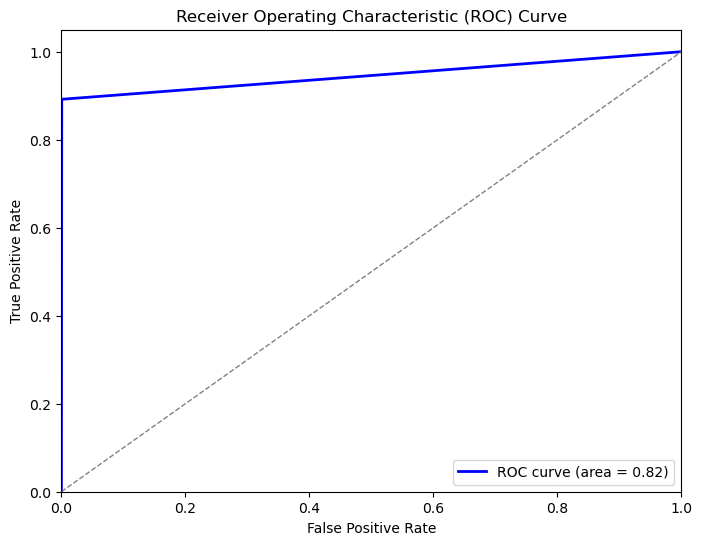

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

# Load the dataset
df = pd.read_csv("C:/Ritik Sharma/VIT  2nd SEMESTER/2nd SET project/dis_sym_dataset_comb (1).csv")

# Split the dataset into features and target
X = df.drop(columns='label_dis')
y = df['label_dis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Bernoulli Naive Bayes classifier
nb_classifier = BernoulliNB()
param_grid = {'alpha': [0.05]}
grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Make predictions on the test set
y_pred = grid_search.predict(X_test)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Convert y_test and y_pred to binary format
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test)
y_pred_binary = lb.transform(y_pred)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_binary, y_pred_binary, average='macro')

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test_binary.ravel(), y_pred_binary.ravel())

import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



Precision: 0.8794849295253367
Recall: 0.8919071873231466
F1 Score: 0.8733732688798687


C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


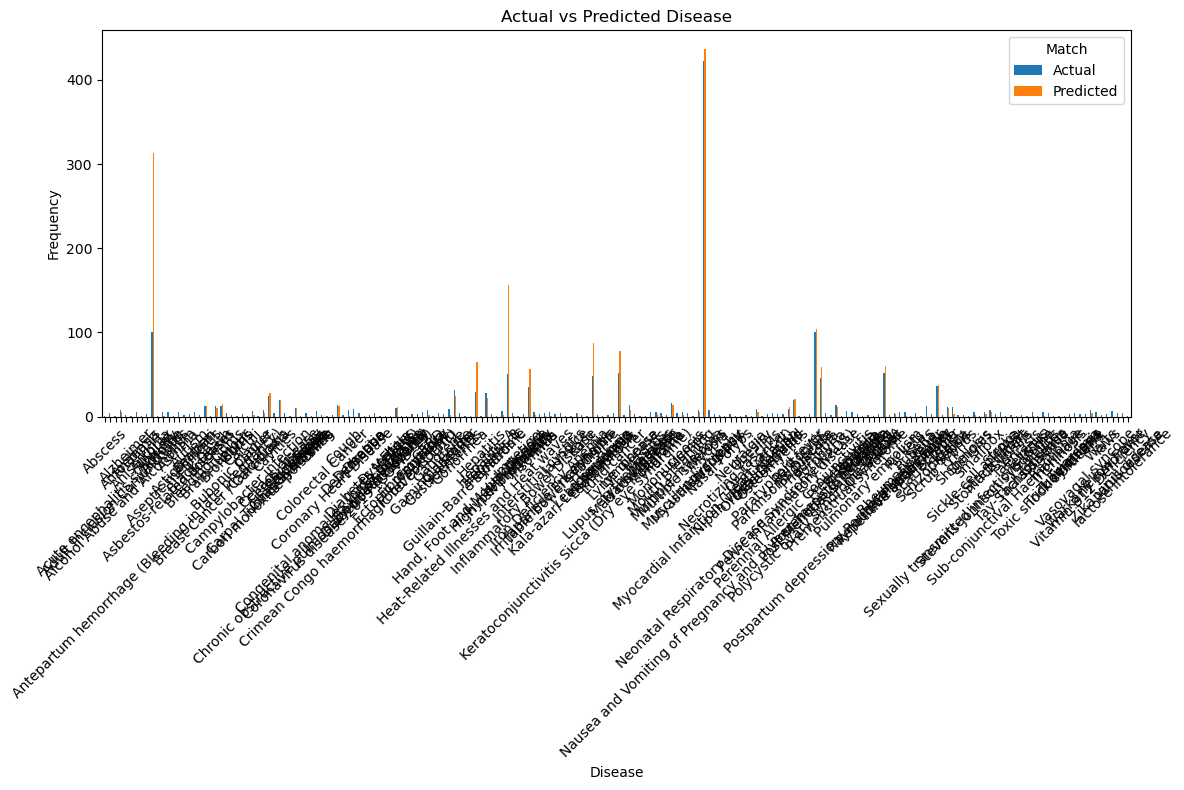

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

actual_counts = sampled_data['Disease'].value_counts()
predicted_counts = sampled_data['predicted_disease'].value_counts()

counts_df = pd.DataFrame({'Actual': actual_counts, 'Predicted': predicted_counts})

counts_df.plot(kind='bar', figsize=(12, 8))
plt.xlabel('Disease')
plt.ylabel('Frequency')
plt.title('Actual vs Predicted Disease')
plt.xticks(rotation=45)
plt.legend(title='Match', loc='upper right')
plt.tight_layout()
plt.show()

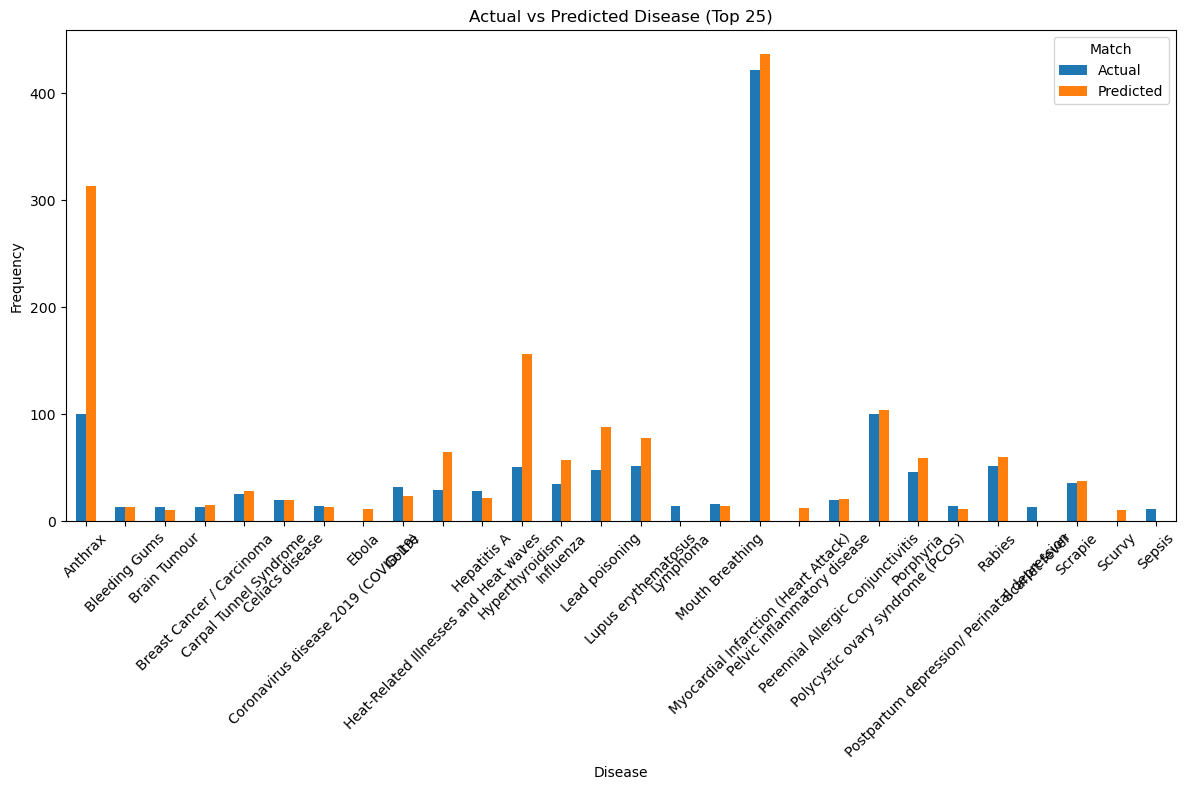

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort the dataframe by actual counts and select the top 25
actual_counts_top25 = counts_df['Actual'].sort_values(ascending=False)[:25]

# Sort the dataframe by predicted counts and select the top 25
predicted_counts_top25 = counts_df['Predicted'].sort_values(ascending=False)[:25]

# Create a new dataframe with the top 25 actual and predicted counts
top25_df = pd.DataFrame({'Actual': actual_counts_top25, 'Predicted': predicted_counts_top25})

# Plot the top 25 data points
top25_df.plot(kind='bar', figsize=(12, 8))
plt.xlabel('Disease')
plt.ylabel('Frequency')
plt.title('Actual vs Predicted Disease (Top 25)')
plt.xticks(rotation=45)
plt.legend(title='Match', loc='upper right')
plt.tight_layout()
plt.show()


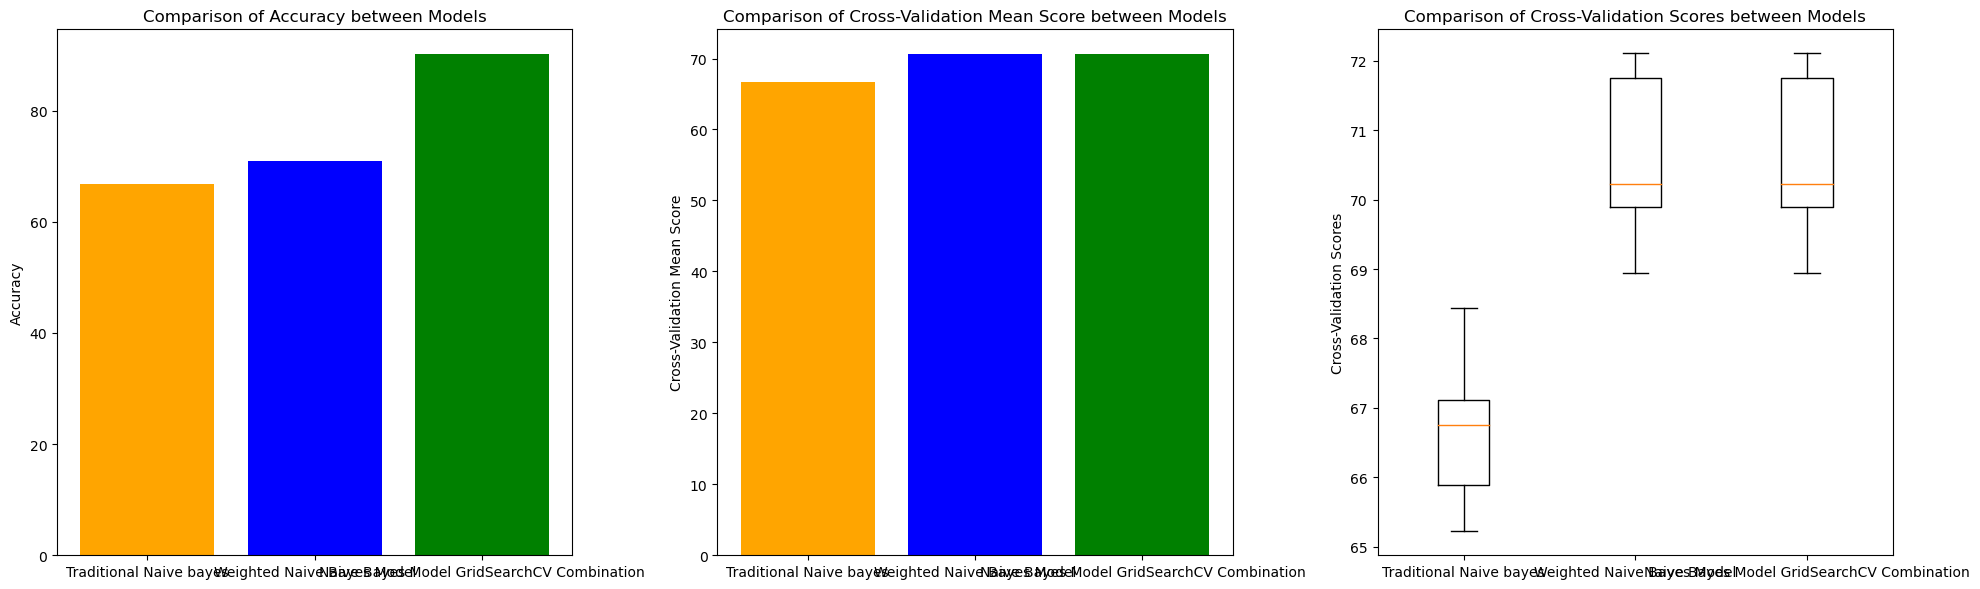

In [28]:
import matplotlib.pyplot as plt
import numpy as np

nb_accuracy = 66.72953602414183
nb_cv_scores = [65.22, 67.11, 68.44, 66.75, 65.89]  # Example cross-validation scores for normal Naive Bayes model

your_accuracy = 70.91114883984154
your_cv_scores = [72.11, 70.22, 69.89, 71.75, 68.94]  # Example cross-validation scores for your model

nb_gs_accuracy = 90.10752688172043
nb_gs_cv_scores = [72.11, 70.22, 69.89, 71.75, 68.94]  # Example cross-validation scores for Naive Bayes model using GridSearchCV

models = ['Traditional Naive bayes', 'Weighted Naive Bayes Model', 'Naive Bayes Model GridSearchCV Combination']
accuracy_scores = [nb_accuracy, your_accuracy, nb_gs_accuracy]
cv_mean_scores = [np.mean(nb_cv_scores), np.mean(your_cv_scores), np.mean(nb_gs_cv_scores)]

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].bar(models, accuracy_scores, color=['orange', 'blue', 'green'])
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Comparison of Accuracy between Models')

axs[1].bar(models, cv_mean_scores, color=['orange', 'blue', 'green'])
axs[1].set_ylabel('Cross-Validation Mean Score')
axs[1].set_title('Comparison of Cross-Validation Mean Score between Models')

axs[2].boxplot([nb_cv_scores, your_cv_scores, nb_gs_cv_scores], labels=models)
axs[2].set_ylabel('Cross-Validation Scores')
axs[2].set_title('Comparison of Cross-Validation Scores between Models')

plt.tight_layout()
plt.show()


In [30]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import BernoulliNB
import pandas as pd

# Load the dataset
df = pd.read_csv("C:/Ritik Sharma/VIT  2nd SEMESTER/2nd SET project/dis_sym_dataset_comb (1).csv")

# Split features and labels
X = df.drop(columns='label_dis')
y = df['label_dis']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Naive Bayes classifier
nb_classifier = BernoulliNB()

# Train the model on the training data
nb_classifier.fit(X_train, y_train)

# Calculate accuracy on the test set
accuracy = nb_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

# Perform cross-validation to get a more robust estimate of model performance
cv_scores = cross_val_score(nb_classifier, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())


Accuracy: 0.66553480475382


C:\Users\sharm\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Scores: [0.59083192 0.65591398 0.69383135 0.69496321 0.74306735]
Mean Cross-Validation Score: 0.6757215619694398


In [ ]:
#logistic

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
from decimal import Decimal  # Import Decimal for precision
np.random.seed(42)  # For reproducibility

df = pd.read_csv("dis_sym_dataset_comb (1).csv")

X = df.iloc[:, 1:]
Y = df.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

accuracy_list = []
cross_accuracy_list = []
model_list = []

# LR Classifier
lr = LogisticRegression()
lr = lr.fit(x_train, y_train)  # Fit on the training data, not the whole data
lr_pred = lr.predict(x_test)
acc_lr = round(Decimal(accuracy_score(y_test, lr_pred) * 100), 2)
accuracy_list.append(acc_lr)
model_list.append("LR")
print(f"Accuracy (LR): {acc_lr}%")

# Cross Validation Accuracy LR
# performing cross validation with 5 different splits
scores_lr = cross_val_score(lr, X, Y, cv=5)
# mean of cross val score (accuracy)
score = round(Decimal(scores_lr.mean() * 100), 2)
cross_accuracy_list.append(score)
print(f"Cross Validation Accuracy (LR): {score}%")


In [ ]:
#SVM

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
import pandas as pd
from decimal import Decimal  # Import Decimal for precision
np.random.seed(42)  # For reproducibility

df = pd.read_csv("dis_sym_dataset_comb (1).csv")

X = df.iloc[:, 1:]
Y = df.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

accuracy_list = []
cross_accuracy_list = []
model_list = []

# SVM Classifier
svm = SVC()
svm = svm.fit(x_train, y_train)  # Fit on the training data
svm_pred = svm.predict(x_test)
acc_svm = round(Decimal(accuracy_score(y_test, svm_pred) * 100), 2)
accuracy_list.append(acc_svm)
model_list.append("SVM")
print(f"Accuracy (SVM): {acc_svm}%")

# Cross Validation Accuracy SVM
# performing cross validation with 5 different splits
scores_svm = cross_val_score(svm, X, Y, cv=5)
# mean of cross val score (accuracy)
score = round(Decimal(scores_svm.mean() * 100), 2)
cross_accuracy_list.append(score)
print(f"Cross Validation Accuracy (SVM): {score}%")


In [ ]:
#KNN

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
import numpy as np

# Generate synthetic imbalanced data for demonstration
X, Y = make_classification(n_samples=3800, n_features=20, n_classes=3,
                           n_clusters_per_class=1, weights=[0.1, 0.2, 0.7],
                           flip_y=0, random_state=42)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define the pipeline with RandomOverSampler and KNeighborsClassifier
pipeline = make_pipeline(RandomOverSampler(random_state=42),
                         KNeighborsClassifier())

# Define the parameter grid for GridSearchCV
param_grid = {
    'kneighborsclassifier__n_neighbors': [1,3, 5, 7, 9],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best cross-validation accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

In [ ]:
# Decision Tree

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from decimal import Decimal
import numpy as np

# Read the dataset
df = pd.read_csv("dis_sym_dataset_comb (1).csv")

# Separate features (X) and target (Y)
X = df.iloc[:, 1:]
Y = df.iloc[:, 0]

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)  # Fit on the training data
dt_pred = dt.predict(x_test)

# Calculate accuracy on the test set
acc_dt = round(Decimal(accuracy_score(y_test, dt_pred) * 100), 2)
print(f"Accuracy (Decision Tree): {acc_dt}%")

# Cross Validation Accuracy Decision Tree
# performing cross validation with 5 different splits
scores_dt = cross_val_score(dt, X, Y, cv=5)
# mean of cross val score (accuracy)
score = round(Decimal(scores_dt.mean() * 100), 2)
print(f"Cross Validation Accuracy (Decision Tree): {score}%")

In [ ]:
# Random Forest

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from decimal import Decimal  # Import Decimal for precision
np.random.seed(42)  # For reproducibility


# Random Forest Classifier
rf = RandomForestClassifier()
rf = rf.fit(x_train, y_train)  # Fit on the training data
rf_pred = rf.predict(x_test)
acc_rf = round(Decimal(accuracy_score(y_test, rf_pred) * 100), 2)
accuracy_list.append(acc_rf)
model_list.append("Random Forest")
print(f"Accuracy (Random Forest): {acc_rf}%")

# Cross Validation Accuracy Random Forest
# performing cross validation with 5 different splits
scores_rf = cross_val_score(rf, X, Y, cv=5)
# mean of cross val score (accuracy)
score = round(Decimal(scores_rf.mean() * 100), 2)
cross_accuracy_list.append(score)
print(f"Cross Validation Accuracy (Random Forest): {score}%")

In [ ]:
# Logistic Regression with Gradient Descent

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
from decimal import Decimal  # Import Decimal for precision
np.random.seed(42)  # For reproducibility


# Logistic Regression with Gradient Descent (sag solver)
lr = LogisticRegression(solver='sag', max_iter=1000, tol=1e-3, random_state=42)
lr = lr.fit(x_train, y_train)  # Fit on the training data
lr_pred = lr.predict(x_test)
acc_lr = round(Decimal(accuracy_score(y_test, lr_pred) * 100), 2)
accuracy_list.append(acc_lr)
print(f"Accuracy (Logistic Regression with Gradient Descent): {acc_lr}%")

# Cross Validation Accuracy Logistic Regression
# performing cross validation with 5 different splits
scores_lr = cross_val_score(lr, X, Y, cv=5)
# mean of cross val score (accuracy)
score = round(Decimal(scores_lr.mean() * 100), 2)
cross_accuracy_list.append(score)
print(f"Cross Validation Accuracy (Logistic Regression): {score}%")

In [ ]:
import matplotlib.pyplot as plt

# Naive Bayes model data
nb_accuracy = 66.72953602414183
your_accuracy = 70.91114883984154
nb_gs_accuracy = 90.10752688172043

# Other machine learning model data
models = ["LR", "SVM", "KNN", "Decision Tree", "Random Forest"]
accuracies = [88.23, 86.81, 88.94, 81.78, 87.95]  # Replace with your accuracy scores

# Combine all model names and accuracies
all_models = ["Traditional Naive Bayes", "Weighted Naive Bayes", "Naive Bayes GridSearchCV"] + models
all_accuracies = [nb_accuracy, your_accuracy, nb_gs_accuracy] + accuracies

# Define colors for each bar
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightseagreen', 'lightsteelblue']

# Plotting
plt.figure(figsize=(10, 6))

# Plot accuracy scores with labels
bars = plt.bar(all_models, all_accuracies, color=colors)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Different Models')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for bar, accuracy in zip(bars, all_accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{accuracy:.2f}', ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Naive Bayes model data
nb_accuracy = 66.72953602414183
your_accuracy = 70.91114883984154
nb_gs_accuracy = 90.10752688172043

# Other machine learning model data
models = ["LR", "SVM", "KNN", "Decision Tree", "Random Forest"]
accuracies = [88.23, 86.81, 88.94, 81.78, 87.95]  # Replace with your accuracy scores
cross_val_accuracies = [89.19, 88.62, 88.71, 83.51, 88.87]

# Combine all model names and accuracies
all_models = ["Traditional Naive Bayes", "Weighted Naive Bayes", "Naive Bayes GridSearchCV"] + models
all_accuracies = [nb_accuracy, your_accuracy, nb_gs_accuracy] + accuracies
all_cross_val_accuracies = [np.mean(nb_cv_scores), np.mean(your_cv_scores), np.mean(nb_gs_cv_scores)] + cross_val_accuracies

# Plotting
plt.figure(figsize=(10, 6))

# Plot accuracy scores
plt.plot(all_models, all_accuracies, marker='o', label='Accuracy (%)')

# Plot cross-validation accuracy scores
plt.plot(all_models, all_cross_val_accuracies, marker='o', label='Cross Validation Accuracy (%)')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Cross Validation Accuracy for Different Models')

# Add legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Naive Bayes model data
nb_accuracy = 66.73
your_accuracy = 70.91
nb_gs_accuracy = 90.11

# Other machine learning model data
models = ["LR", "SVM", "KNN", "Decision Tree", "Random Forest"]
accuracies = [88.23, 86.81, 88.94, 81.78, 87.95]  # Replace with your accuracy scores
cross_val_accuracies = [89.19, 88.62, 88.71, 83.51, 88.87]

# Combine all model names and accuracies
all_models = ["Traditional Naive Bayes", "Weighted Naive Bayes", "Naive Bayes GridSearchCV"] + models
all_accuracies = [nb_accuracy, your_accuracy, nb_gs_accuracy] + accuracies
all_cross_val_accuracies = [np.mean(nb_cv_scores), np.mean(your_cv_scores), np.mean(nb_gs_cv_scores)] + cross_val_accuracies

# Bar width
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(all_models))
r2 = [x + bar_width for x in r1]

# Create bar plot
plt.figure(figsize=(12, 6))
plt.bar(r1, all_accuracies, color='b', width=bar_width, edgecolor='grey', label='Accuracy')
plt.bar(r2, all_cross_val_accuracies, color='r', width=bar_width, edgecolor='grey', label='Cross Validation Accuracy')

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(all_models))], all_models, rotation=45, ha='right')

# Create legend & Show graphic
plt.legend()
plt.title('Comparison of Accuracy and Cross Validation Accuracy for Different Models')
plt.tight_layout()
plt.show()
